In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange
from math import floor

%load_ext autoreload
%autoreload 2

from utils import *
from rd_transformer import *
from tokenizer_bpe import *

In [2]:
path = 'F:/$daten/datasets/commonlitreadabilityprize/'
#df = pd.read_csv(path + 'electronics.csv', sep=';').fillna('')
df_train = pd.read_csv(path + 'encoded_train.csv').fillna('')
df_val = pd.read_csv(path + 'encoded_val.csv').fillna('')
df_train

Unnamed: 0                                            excerpt    target  \
0              1  All through dinner time, Mrs. Fayre was somewh... -0.315372   
1              2  As Roger had predicted, the snow departed as q... -0.580118   
2              3  And outside before the palace a great garden w... -1.054013   
3              4  Once upon a time there were Three Bears who li...  0.247197   
4              5  Hal and Chester found ample time to take an in... -0.861809   
...          ...                                                ...       ...   
2545        2828  Near the top of the world is land called tundr...  0.608108   
2546        2829  When you think of dinosaurs and where they liv...  1.711390   
2547        2831  The second state of matter we will discuss is ...  0.255209   
2548        2832  Solids are shapes that you can actually touch.... -0.215279   
2549        2833  Animals are made of many cells. They eat thing...  0.300779   

                                                encoded  
0     ['A', 'll', '</w>', 'through', '</w>', 'd', 'i...  
1     ['As', '</w>', 'R', 'o', 'ger', '</w>', 'had',...  
2     ['And', '</w>', 'ou', 't', 'side', '</w>', 'be...  
3     ['On', 'ce', '</w>', 'upon', '</w>', 'a', '</w...  
4     ['H', 'al', '</w>', 'and', '</w>', 'C', 'he', ...  
...                                                 ...  
2545  ['N', 'ear', '</w>', 'the', '</w>', 'to', 'p',...  
2546  ['When', '</w>', 'you', '</w>', 'think', '</w>...  
2547  ['The', '</w>', 'secon', 'd', '</w>', 'st', 'a...  
2548  ['S', 'o', 'li', 'ds', '</w>', 'are', '</w>', ...  
2549  ['An', 'im', 'als', '</w>', 'are', '</w>', 'ma...  

[2550 rows x 4 columns]

In [3]:
tokenizer = Tokenizer()
tokenizer.t2i, tokenizer.i2t, tokenizer.bpe_code = torch.load('readability_tokenizer.dat')
tokenizer.t2i = defaultdict(lambda: tokenizer.t2i['<U>'], tokenizer.t2i)
tokenizer.t2i['<U>'] = len(tokenizer.t2i)
tokenizer.i2t = { i: t for t, i in tokenizer.t2i.items() }
tokenizer.NTOK = len(tokenizer.t2i)+10

In [4]:
MAX_LEN = 80 # maximale Anzahl Tokens

In [5]:
tokenizer.t2i
#tokenizer.tokenize('Hello great world!', ints=False)

defaultdict(<function __main__.<lambda>()>,
            {'last': 0,
             'ate': 1,
             'his': 2,
             'tter': 3,
             'tween': 4,
             're': 5,
             'ened': 6,
             'V': 7,
             'brain': 8,
             '$': 9,
             'Mr': 10,
             'ft': 11,
             'hou': 12,
             'til': 13,
             'war': 14,
             'ins': 15,
             'before': 16,
             'eng': 17,
             'ri': 18,
             'help': 19,
             '_': 20,
             'ö': 21,
             'bo': 22,
             '&': 23,
             'ld': 24,
             'tree': 25,
             'g': 26,
             'mon': 27,
             'ic': 28,
             'live': 29,
             'cer': 30,
             'information': 31,
             's': 32,
             'od': 33,
             'after': 34,
             '[': 35,
             'ned': 36,
             '</S>': 37,
             'ck': 38,
             'This': 39,
      

In [20]:
def encode(string, evl=True, rnd=True):
    'Tokenizes and encodes a string to a format suitable for the neural network'
    if evl: tokens = eval(string)
    else: tokens = string
    if len(tokens) > MAX_LEN and rnd:
        i = np.random.randint(0, len(tokens)-MAX_LEN-1)
        tokens = tokens[i:i+MAX_LEN]
    tokens = ['<S>'] + tokens
    tokens = tokenizer.tokenize(tokens, encd=False)
    x = np.zeros(MAX_LEN+1, dtype=int)
    x[:] = tokenizer.t2i['</S>']
    for k, l in enumerate(tokens[:MAX_LEN+1]):
        x[k] = l
    x = x[:MAX_LEN+1]
    return x
    

def target_bin(z):
    # z is in the interval (-3.676267773, 1.711389827)
    z = (z+3.7) / (1.72 + 3.7)
    return int(floor(z*NBINS))
    

def batchgen(bsize=64):
    N = len(df_train)
    ep = 0
    while True:
        inds = np.random.permutation(range(N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = np.zeros((bsize, MAX_LEN+1), dtype=int)
            zs = np.zeros((bsize))
            for i, j in enumerate(mb):
                x = df_train['encoded'][j]
                z = df_train['target'][j]
                xs[i] = encode(x)
                zs[i] = target_bin(z)
                assert target_bin(z) < NBINS
            yield xs[:,:-1], zs
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1
    
bg = batchgen()
xs, zs = next(bg)
tokenizer.detokenize(list(xs[0])), zs

('<S>and get warm.\nThe flies fly from flower to flower. They help the flowers make seeds.\nCaribou eat the flowers. The caribou also give the plants',
 array([15.,  7.,  6., 16., 10.,  4.,  6., 13.,  8.,  5., 10.,  2.,  1.,
        12., 12.,  7., 12.,  8., 13.,  9., 10.,  9., 15., 11., 15., 17.,
        13., 15., 11.,  9., 10.,  7., 17., 12.,  5.,  3.,  5.,  3.,  6.,
         8., 15.,  8., 10., 14., 15., 13., 15.,  8., 13.,  9.,  7., 15.,
         7.,  1.,  9., 18., 10., 11.,  8.,  8.,  5., 10.,  8.,  6.]))

In [7]:
net = Net(n=256, nh=4, ntok=tokenizer.NTOK)
net.optim = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))
net.iters = 0
net.losses = []
net.vlosses = []
bg = batchgen()

In [8]:
for m in net.modules():
    if type(m) == nn.Dropout:
        m.p = 0.5
        print('here')

here
here
here
here
here
here
here
here
here


In [9]:
#weights = torch.load('rd_weights_281123.dat')
#net.load_state_dict(weights, strict=False)

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


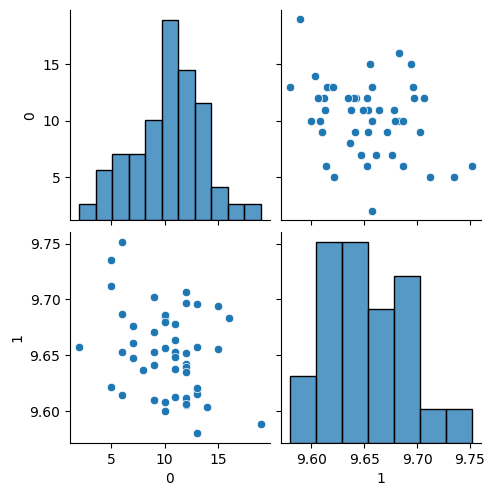

(tensor(3.1024, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.2464, device='cuda:0', grad_fn=<NllLossBackward0>))

In [10]:
def valloss(plot=False):
    net.eval()
    xs, zs = [], []
    for i in range(0, 50):
        x = df_val['encoded'][i]
        z = df_val['target'][i]
        x = encode(x)
        z = target_bin(z)
        xs.append(x)
        zs.append(z)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    loss = F.nll_loss(torch.log_softmax(zp, dim=1), zs.long())
    if plot:
        zp = F.softmax(zp, dim=1)
        zp, zs = t2np(zp, zs)
        zp = np.sum(zp * np.arange(NBINS), -1)
        pairplot(zs, zp)
        plt.show()
    return loss

def Loss():
    net.train()
    xs, zs = next(bg)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    return F.nll_loss(torch.log_softmax(zp, dim=1), zs.long())

valloss(True), Loss()

  0%|          | 0/999999 [00:00<?, ?it/s]

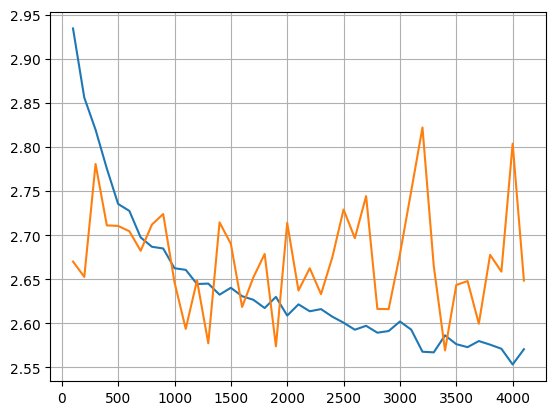

========== EPOCH 0 COMPLETED ==========
========== EPOCH 1 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


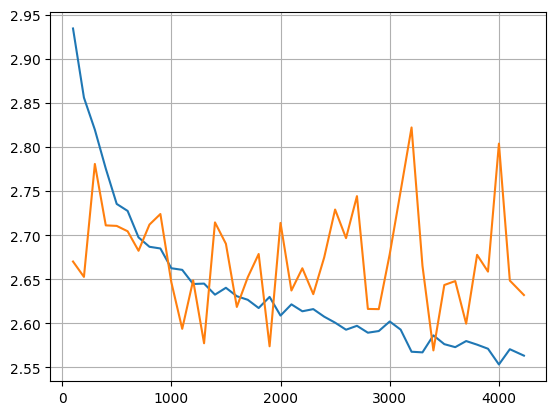

========== EPOCH 2 COMPLETED ==========
========== EPOCH 3 COMPLETED ==========
========== EPOCH 4 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


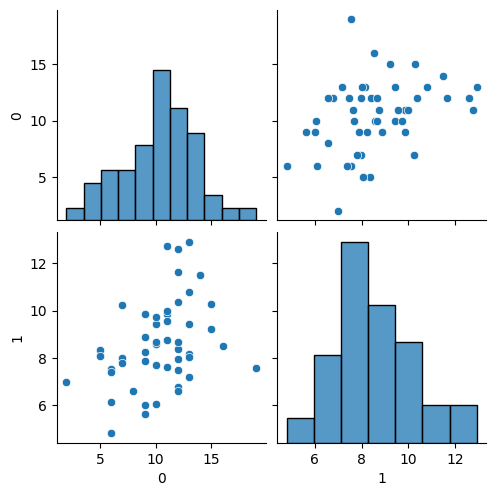

========== EPOCH 5 COMPLETED ==========
========== EPOCH 6 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


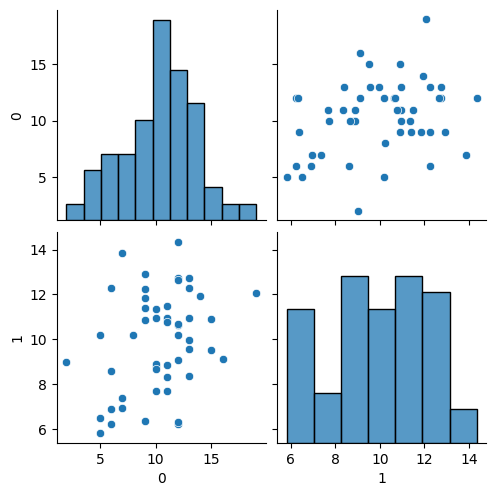

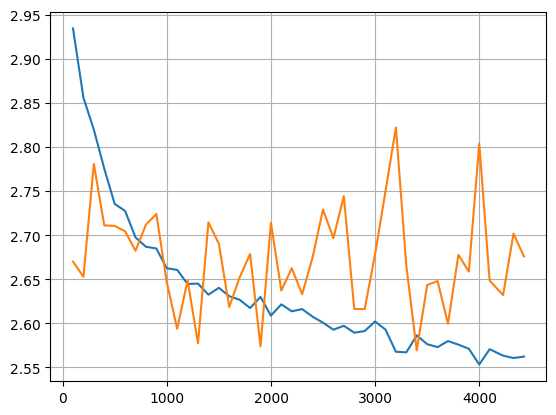

========== EPOCH 7 COMPLETED ==========
========== EPOCH 8 COMPLETED ==========
========== EPOCH 9 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


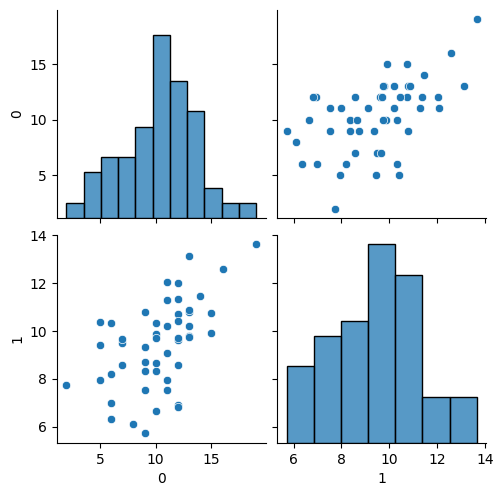

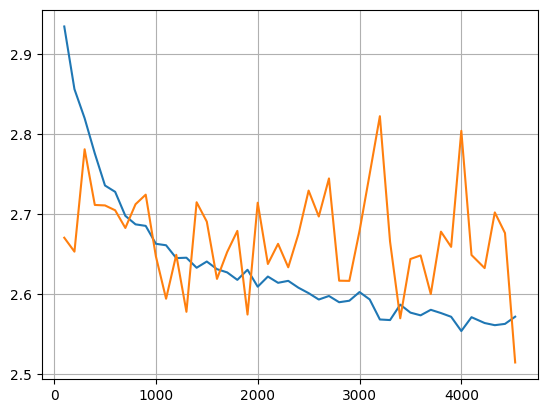

========== EPOCH 10 COMPLETED ==========
========== EPOCH 11 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


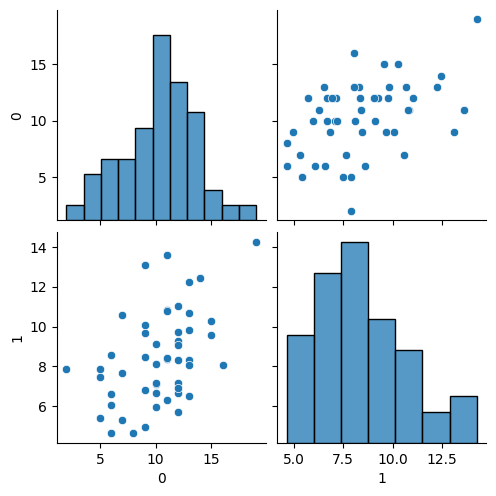

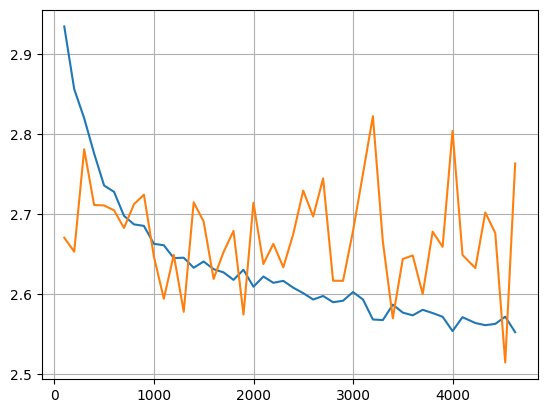

========== EPOCH 12 COMPLETED ==========
========== EPOCH 13 COMPLETED ==========
========== EPOCH 14 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


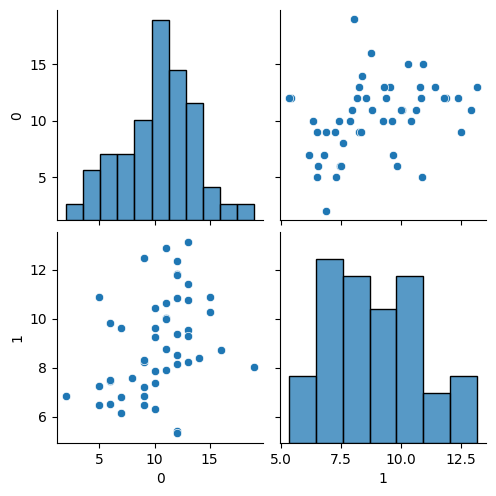

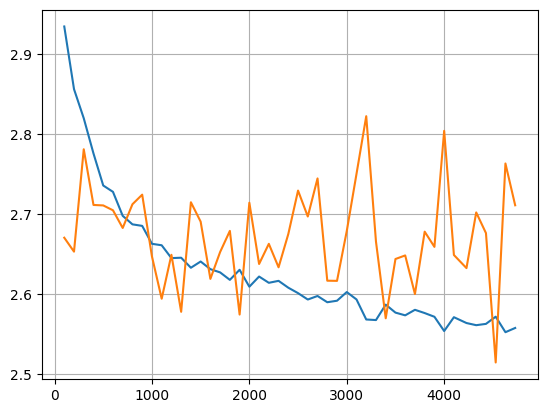

========== EPOCH 15 COMPLETED ==========
========== EPOCH 16 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


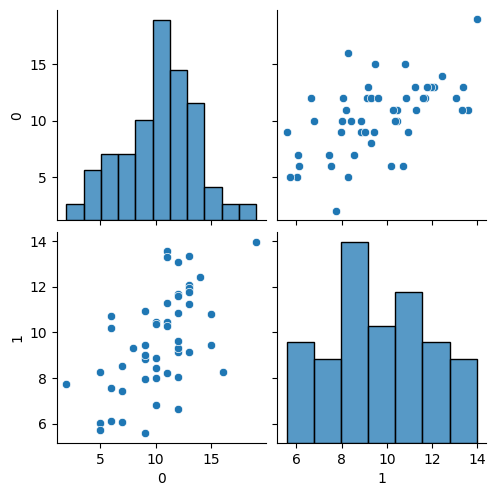

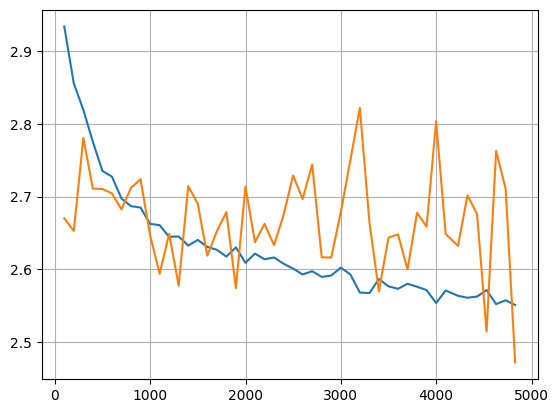

========== EPOCH 17 COMPLETED ==========
========== EPOCH 18 COMPLETED ==========
========== EPOCH 19 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


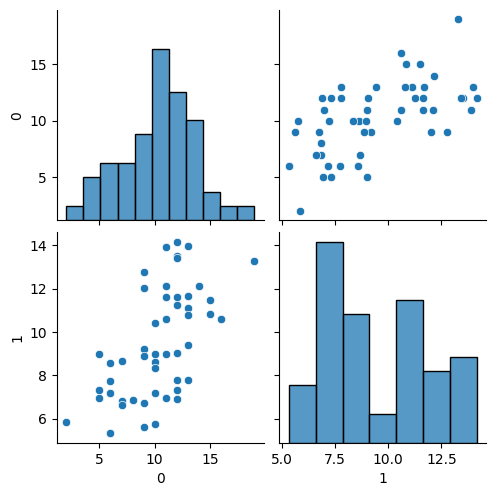

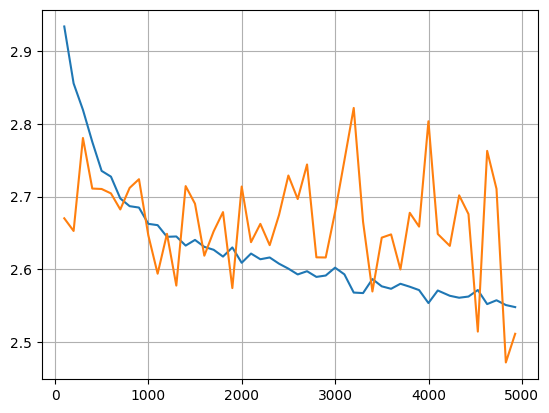

========== EPOCH 20 COMPLETED ==========
========== EPOCH 21 COMPLETED ==========
========== EPOCH 22 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


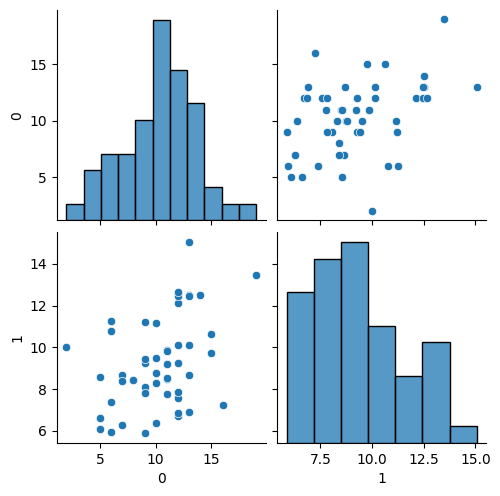

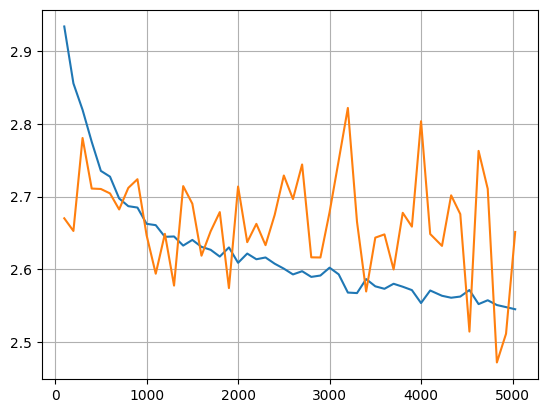

========== EPOCH 23 COMPLETED ==========
========== EPOCH 24 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


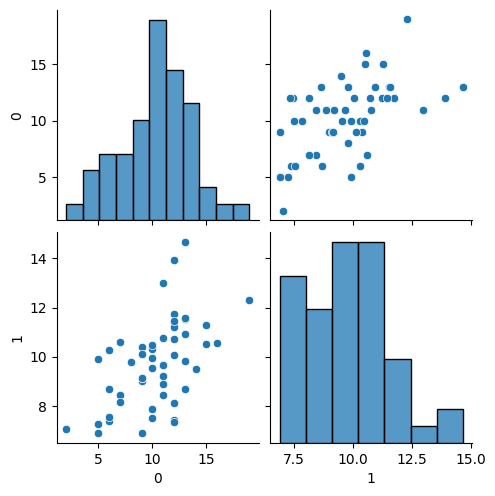

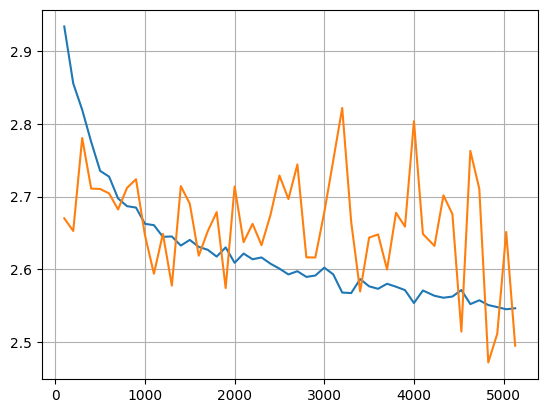

========== EPOCH 25 COMPLETED ==========
========== EPOCH 26 COMPLETED ==========
========== EPOCH 27 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


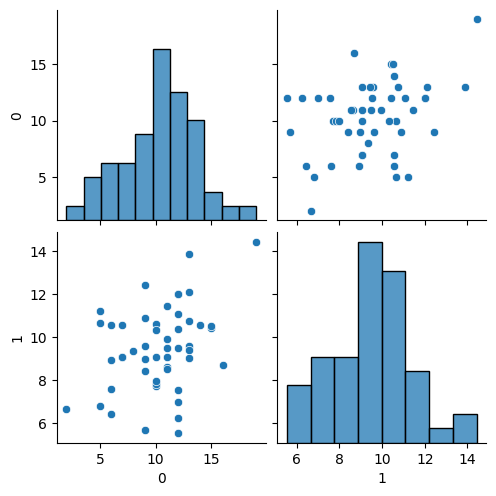

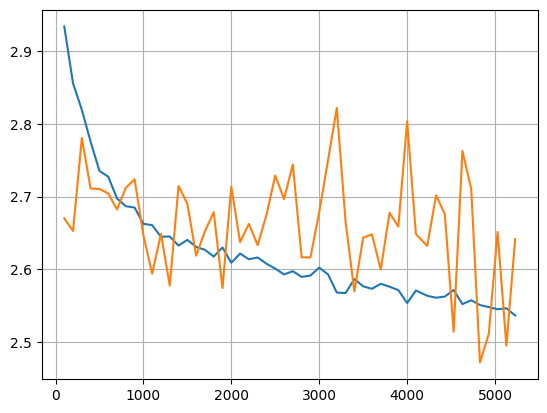

========== EPOCH 28 COMPLETED ==========
========== EPOCH 29 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


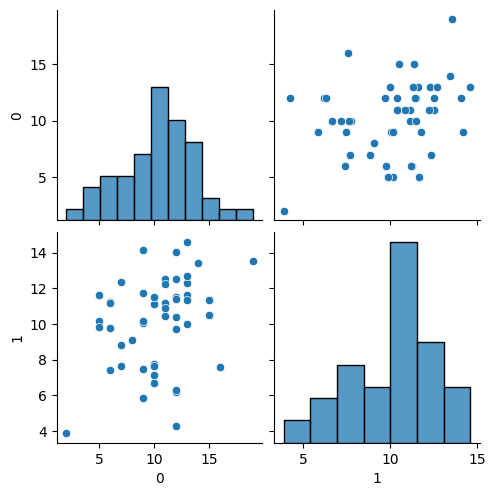

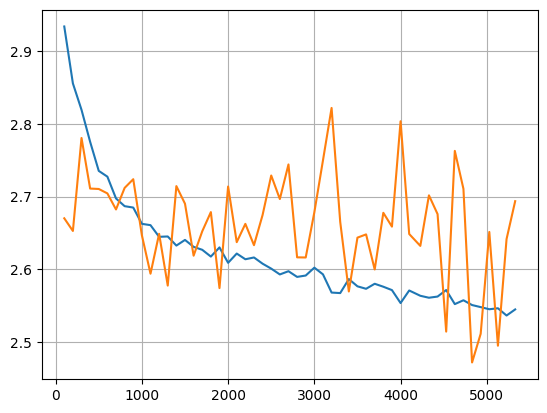

========== EPOCH 30 COMPLETED ==========
========== EPOCH 31 COMPLETED ==========
========== EPOCH 32 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


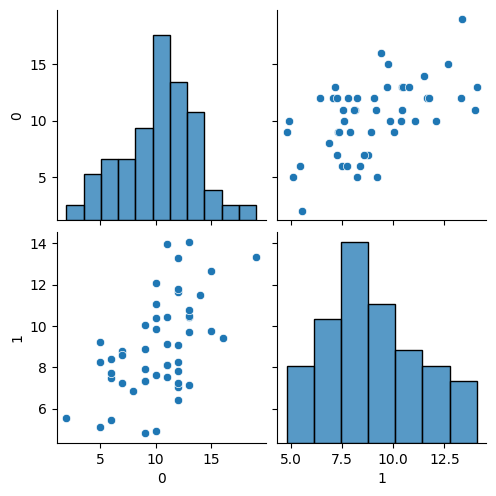

========== EPOCH 33 COMPLETED ==========
========== EPOCH 34 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


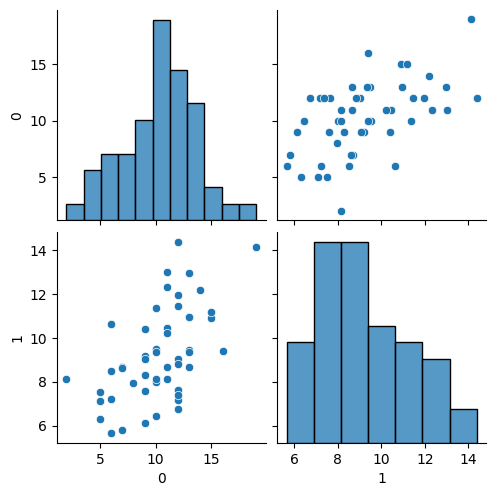

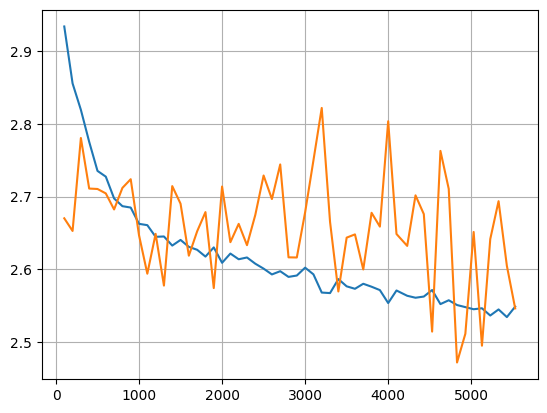

========== EPOCH 35 COMPLETED ==========
========== EPOCH 36 COMPLETED ==========
========== EPOCH 37 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


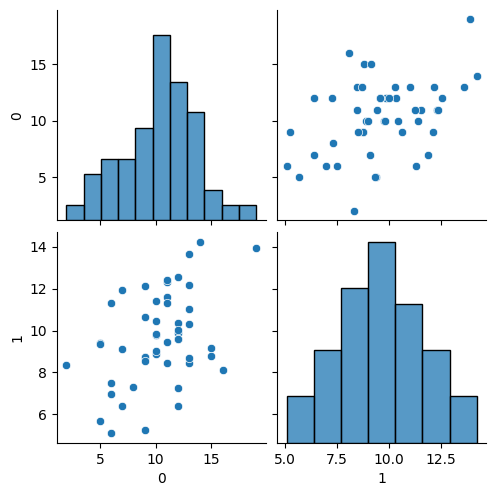

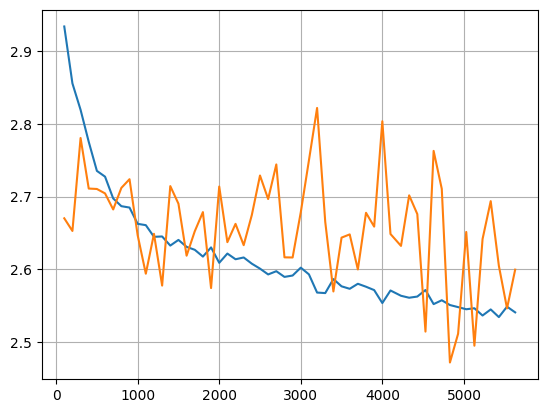

========== EPOCH 38 COMPLETED ==========
========== EPOCH 39 COMPLETED ==========
========== EPOCH 40 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


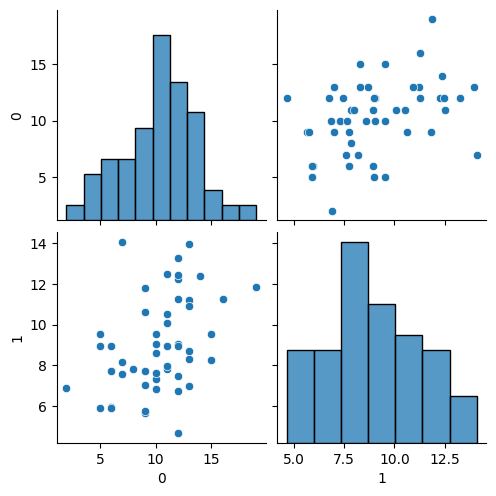

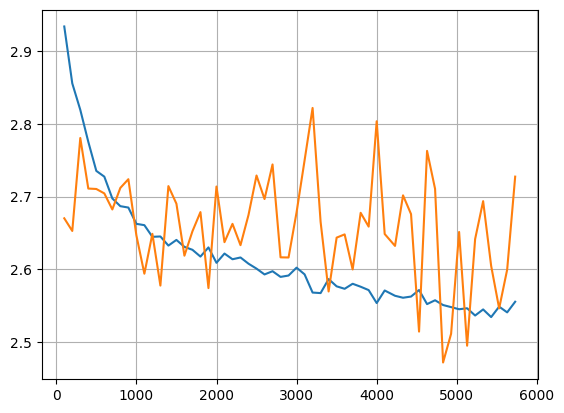

========== EPOCH 41 COMPLETED ==========
========== EPOCH 42 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


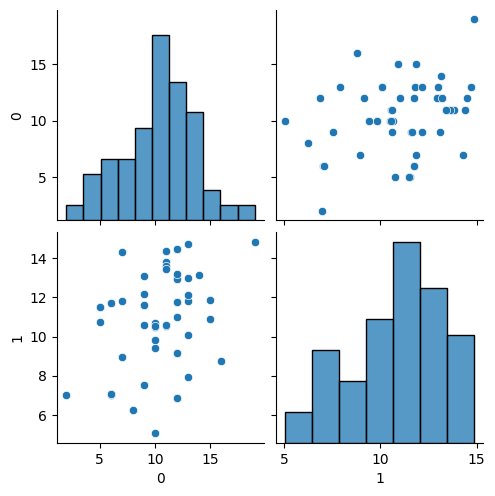

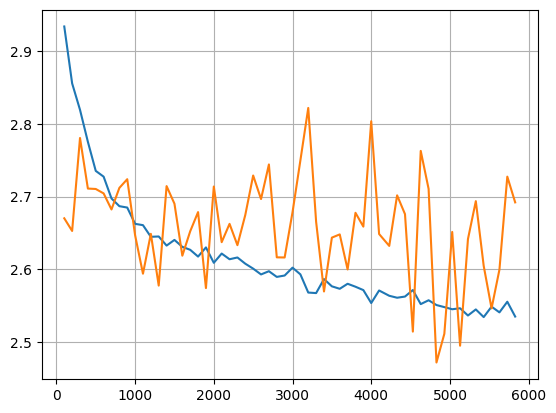

========== EPOCH 43 COMPLETED ==========
========== EPOCH 44 COMPLETED ==========
========== EPOCH 45 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


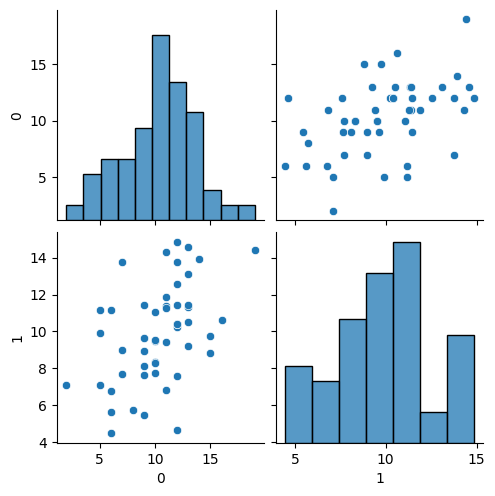

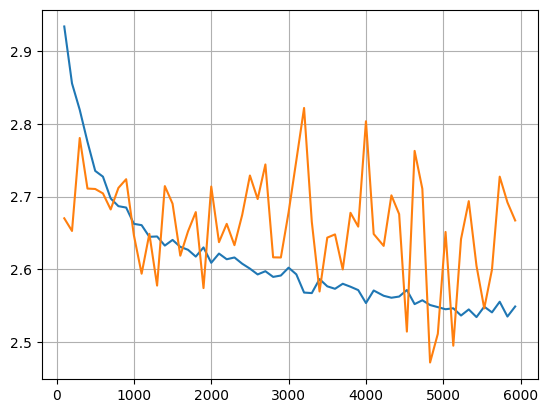

========== EPOCH 46 COMPLETED ==========
========== EPOCH 47 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


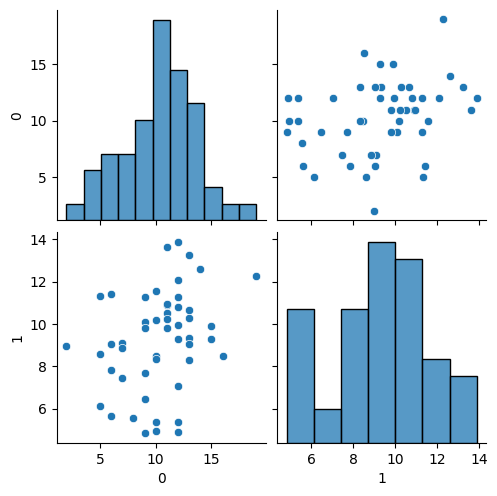

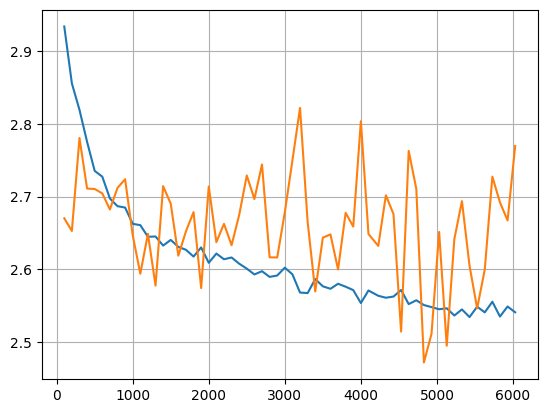

========== EPOCH 48 COMPLETED ==========
========== EPOCH 49 COMPLETED ==========
========== EPOCH 50 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


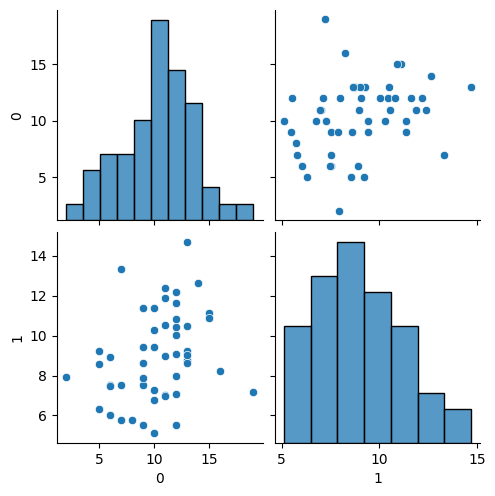

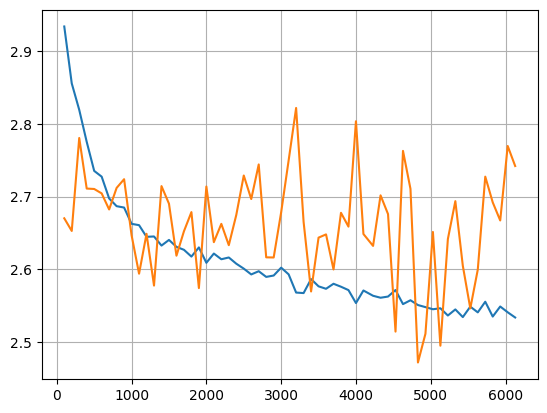

========== EPOCH 51 COMPLETED ==========
========== EPOCH 52 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


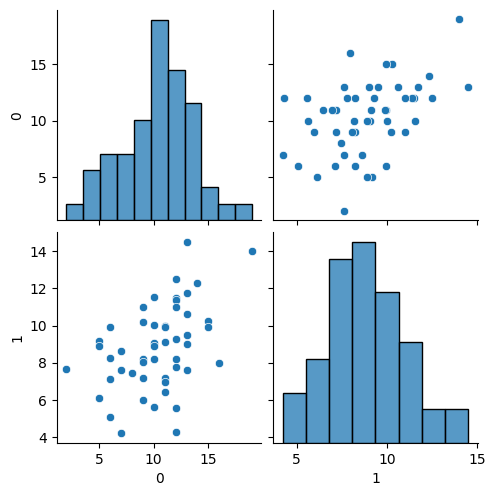

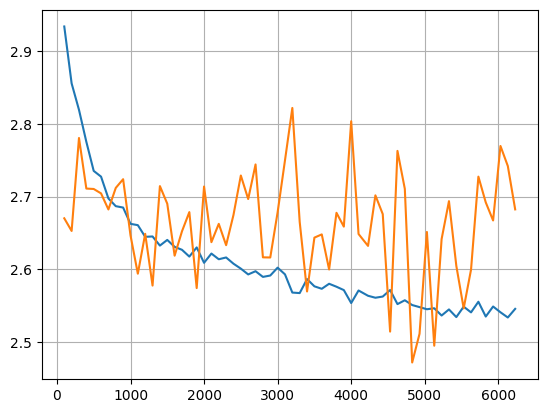

========== EPOCH 53 COMPLETED ==========
========== EPOCH 54 COMPLETED ==========
========== EPOCH 55 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


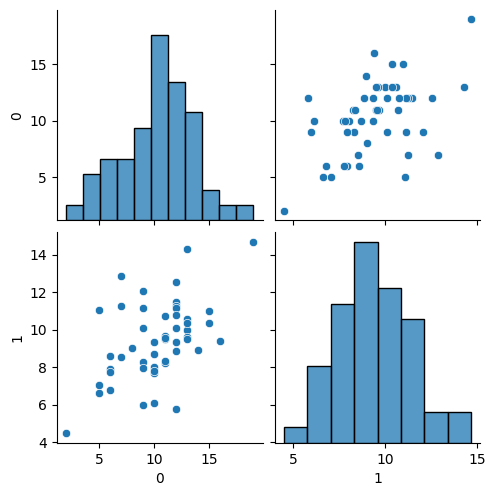

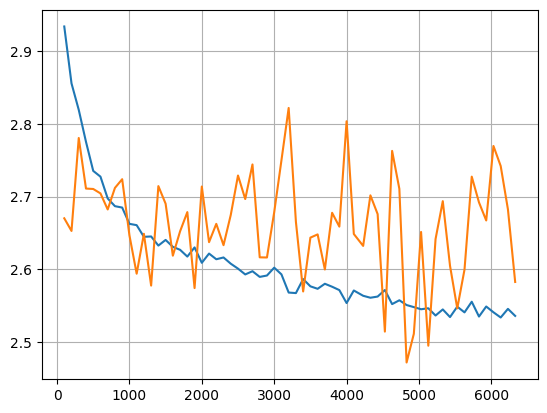

========== EPOCH 56 COMPLETED ==========
========== EPOCH 57 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


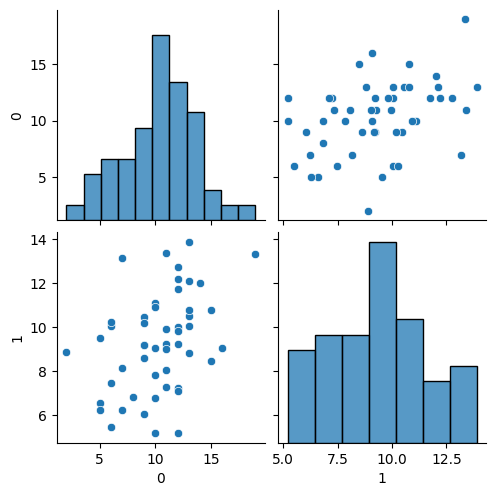

========== EPOCH 58 COMPLETED ==========


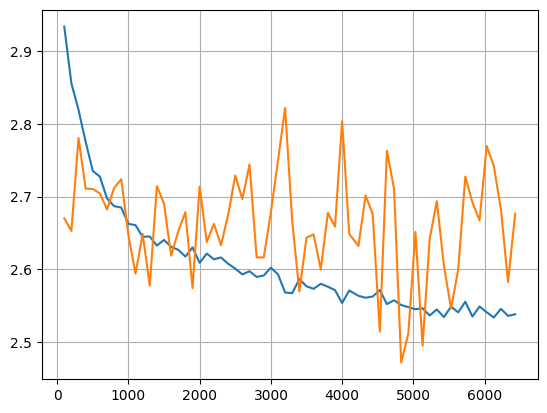

========== EPOCH 59 COMPLETED ==========
========== EPOCH 60 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


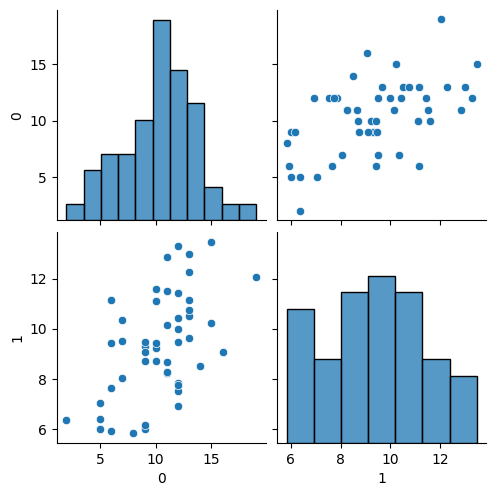

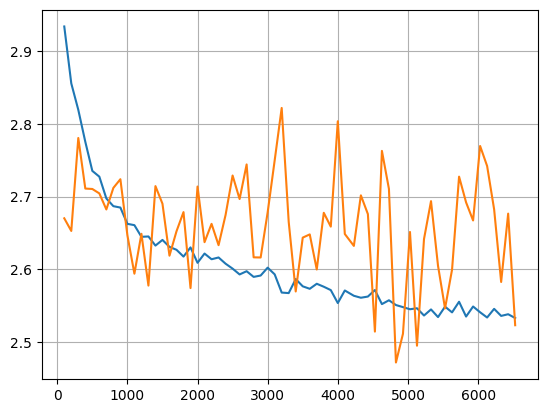

========== EPOCH 61 COMPLETED ==========
========== EPOCH 62 COMPLETED ==========
========== EPOCH 63 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


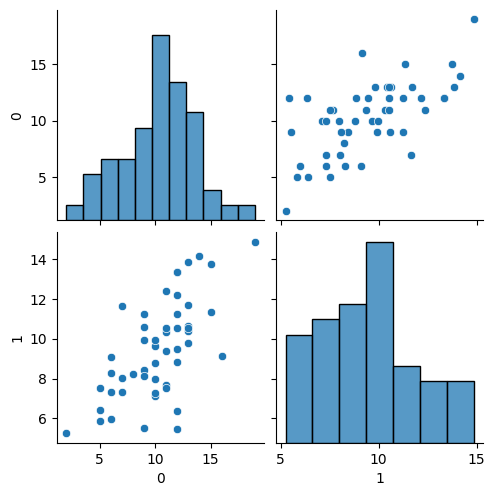

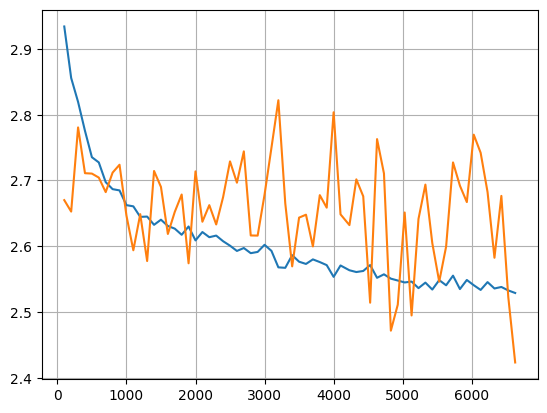

========== EPOCH 64 COMPLETED ==========
========== EPOCH 65 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


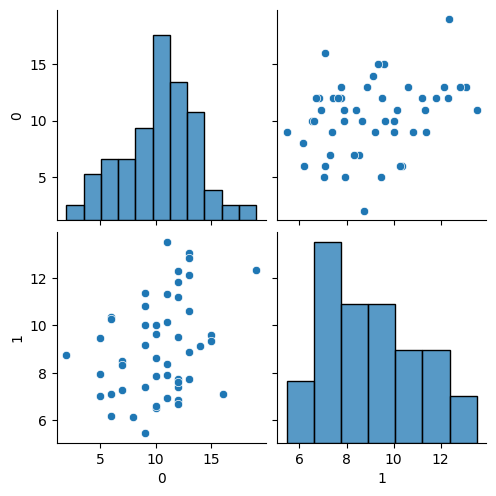

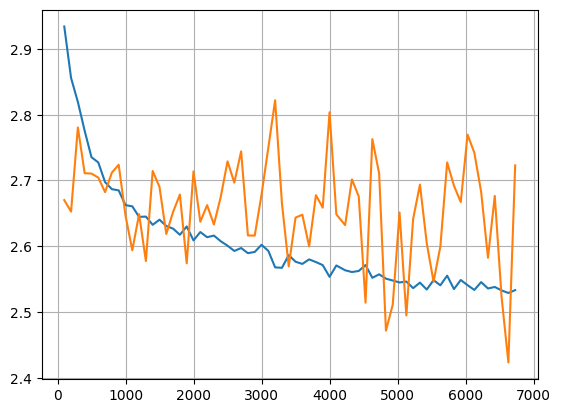

========== EPOCH 66 COMPLETED ==========
========== EPOCH 67 COMPLETED ==========
========== EPOCH 68 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


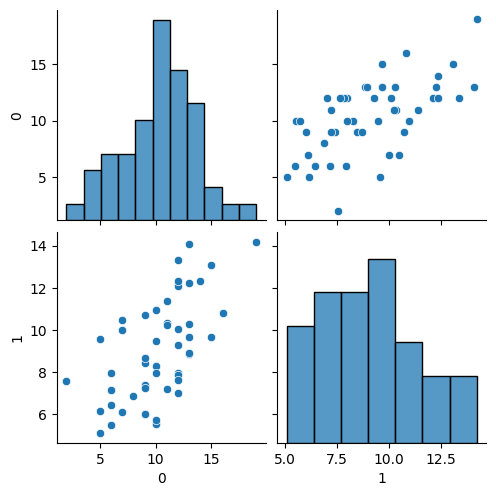

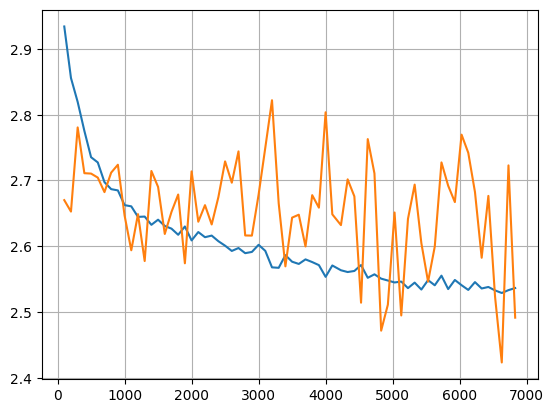

========== EPOCH 69 COMPLETED ==========
========== EPOCH 70 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


========== EPOCH 71 COMPLETED ==========
========== EPOCH 72 COMPLETED ==========
========== EPOCH 73 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


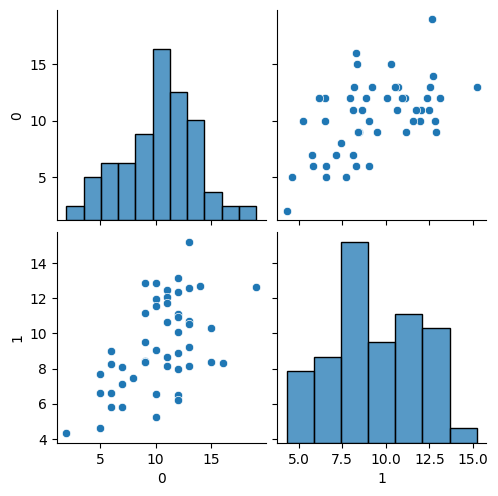

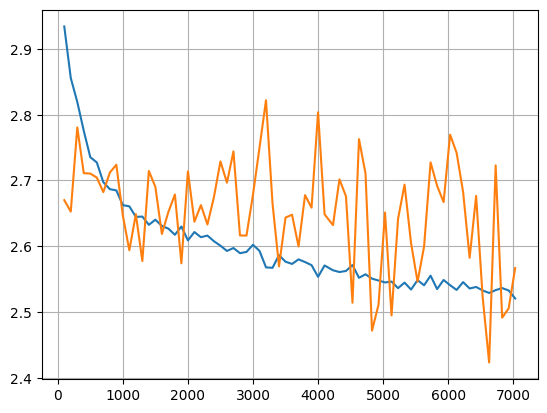

========== EPOCH 74 COMPLETED ==========
========== EPOCH 75 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


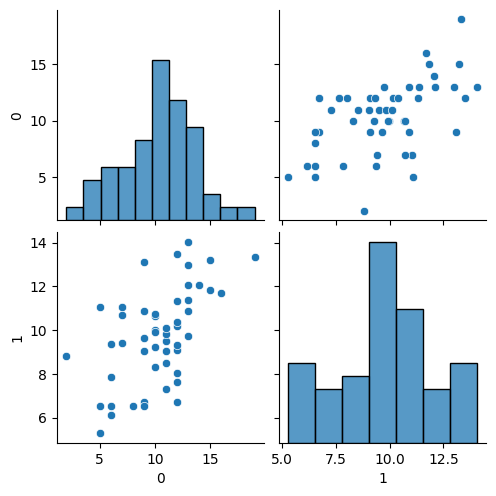

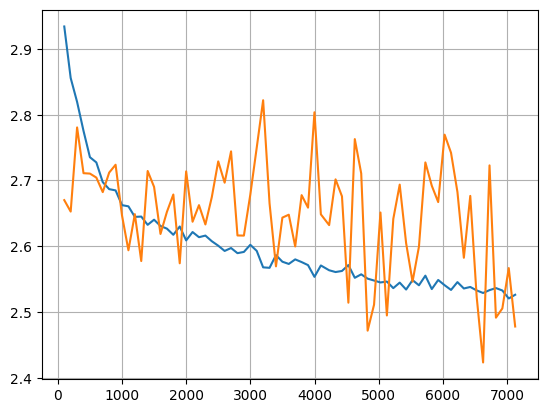

========== EPOCH 76 COMPLETED ==========
========== EPOCH 77 COMPLETED ==========
========== EPOCH 78 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


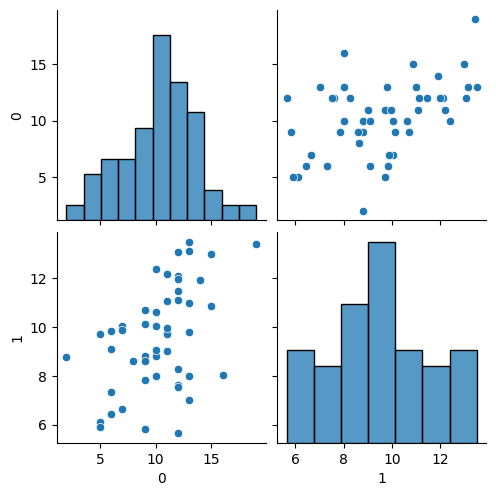

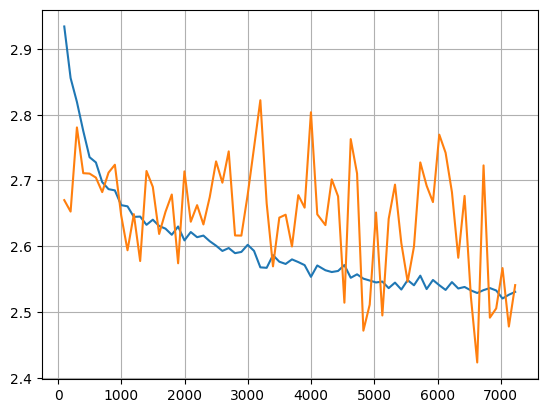

========== EPOCH 79 COMPLETED ==========
========== EPOCH 80 COMPLETED ==========
========== EPOCH 81 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


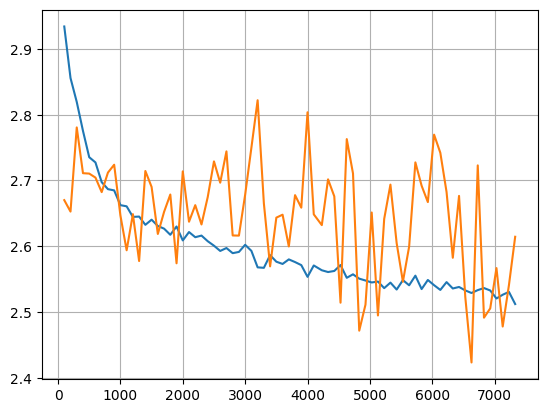

========== EPOCH 82 COMPLETED ==========
========== EPOCH 83 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


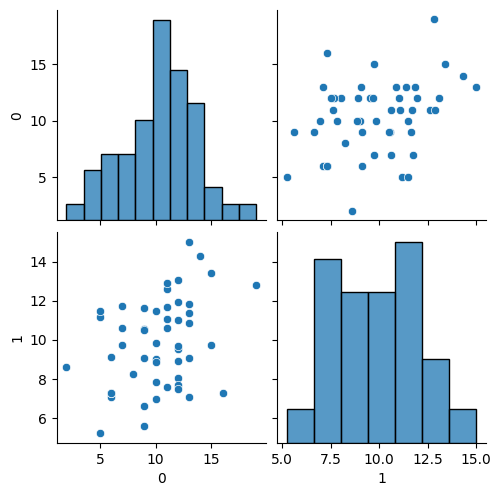

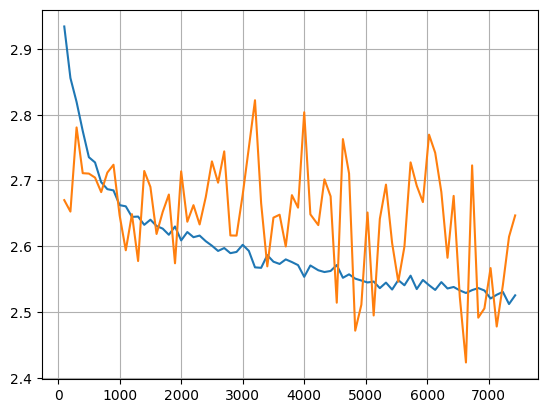

========== EPOCH 84 COMPLETED ==========
========== EPOCH 85 COMPLETED ==========
========== EPOCH 86 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


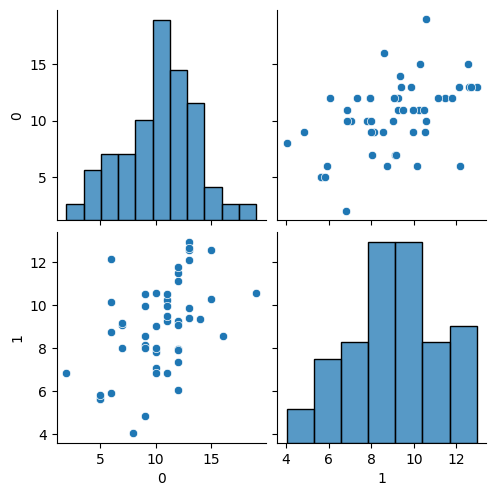

========== EPOCH 87 COMPLETED ==========
========== EPOCH 88 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


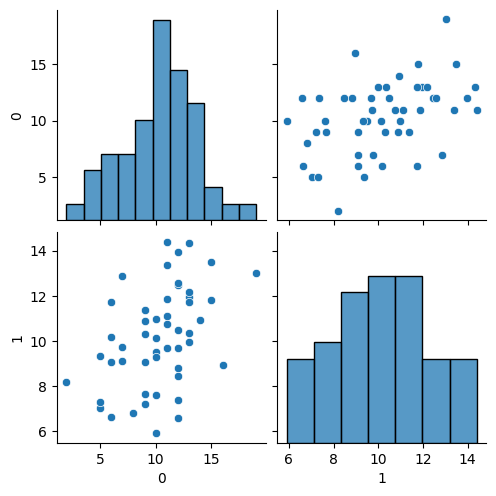

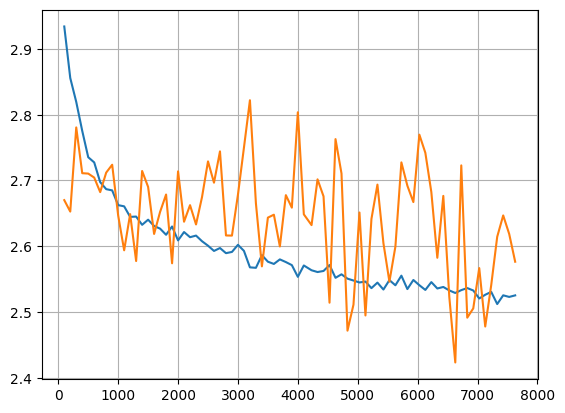

========== EPOCH 89 COMPLETED ==========
========== EPOCH 90 COMPLETED ==========
========== EPOCH 91 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


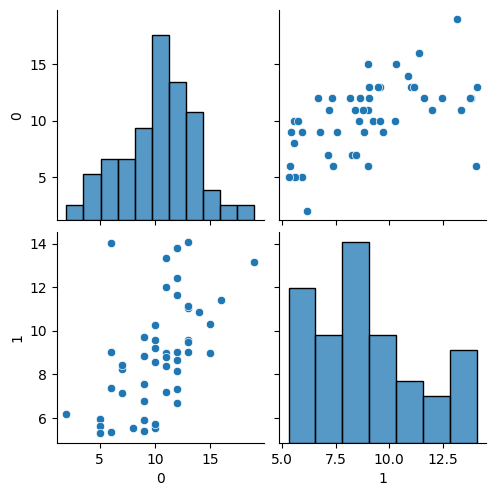

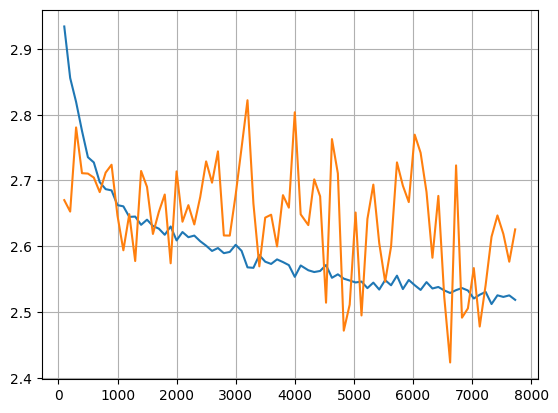

========== EPOCH 92 COMPLETED ==========
========== EPOCH 93 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


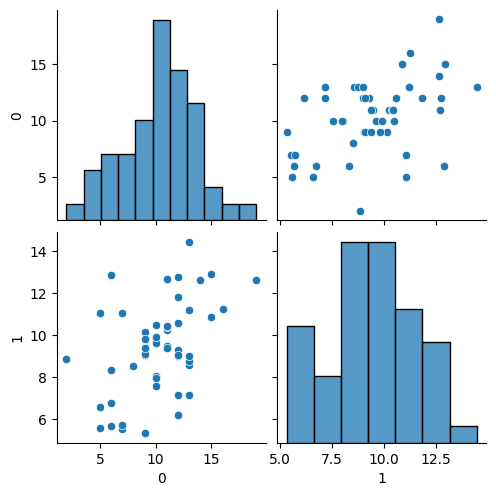

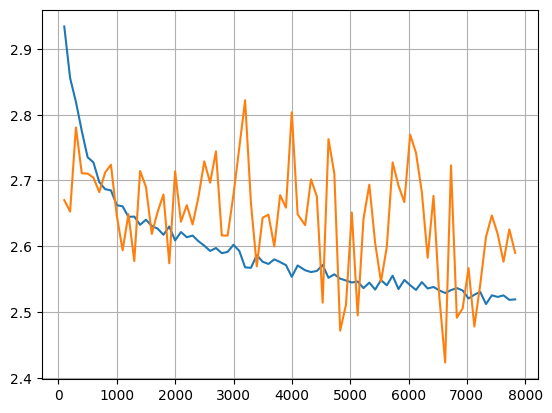

========== EPOCH 94 COMPLETED ==========
========== EPOCH 95 COMPLETED ==========
========== EPOCH 96 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


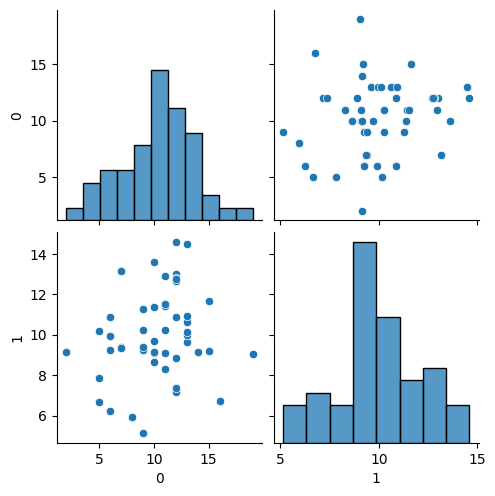

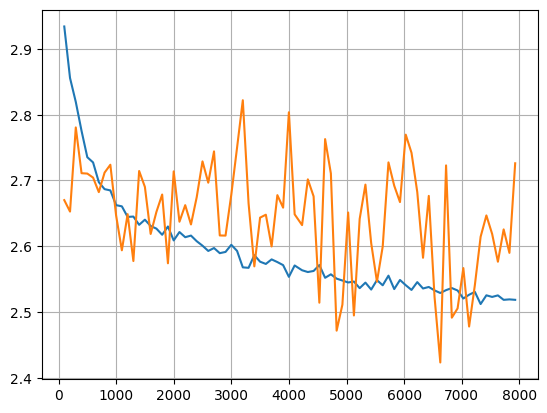

========== EPOCH 97 COMPLETED ==========
========== EPOCH 98 COMPLETED ==========
========== EPOCH 99 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


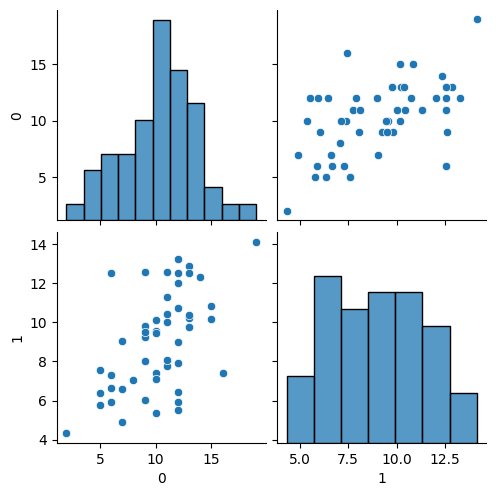

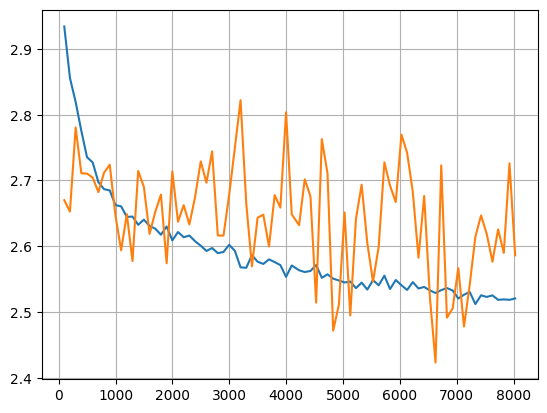

========== EPOCH 100 COMPLETED ==========
========== EPOCH 101 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


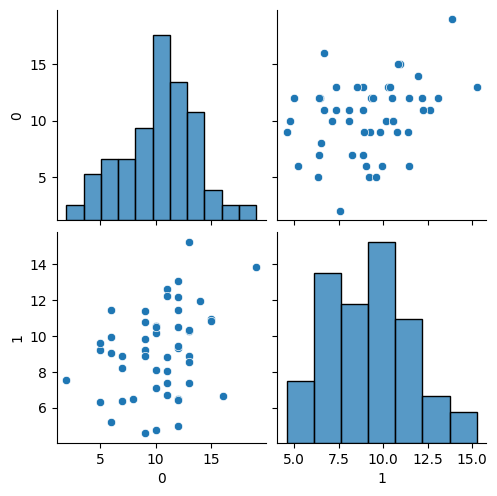

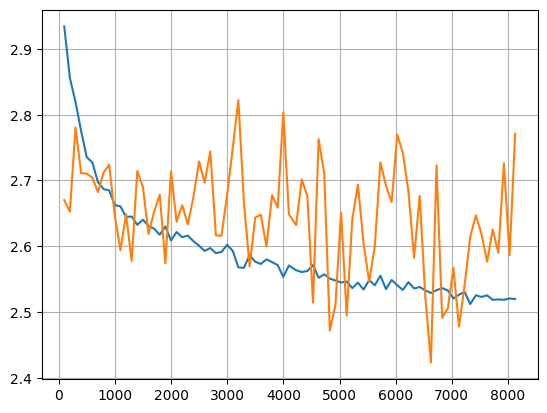

========== EPOCH 102 COMPLETED ==========
========== EPOCH 103 COMPLETED ==========
========== EPOCH 104 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


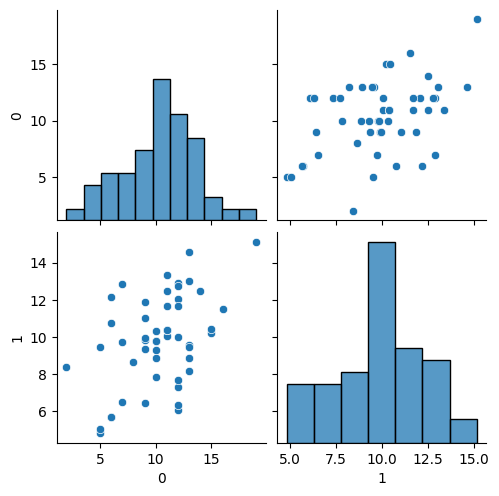

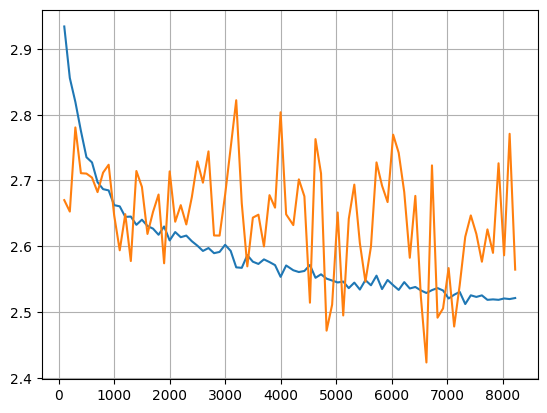

========== EPOCH 105 COMPLETED ==========
========== EPOCH 106 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


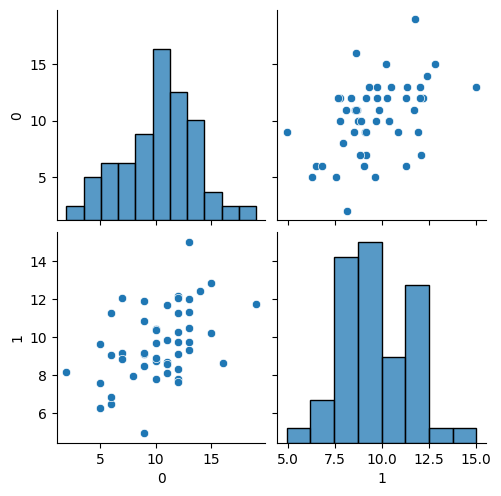

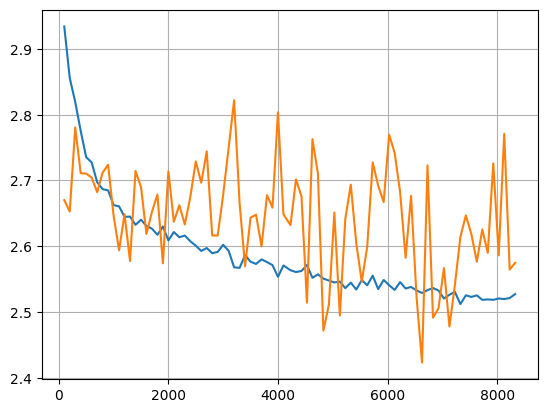

========== EPOCH 107 COMPLETED ==========
========== EPOCH 108 COMPLETED ==========
========== EPOCH 109 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


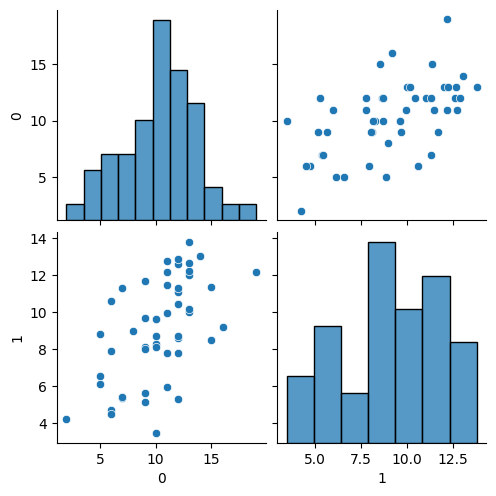

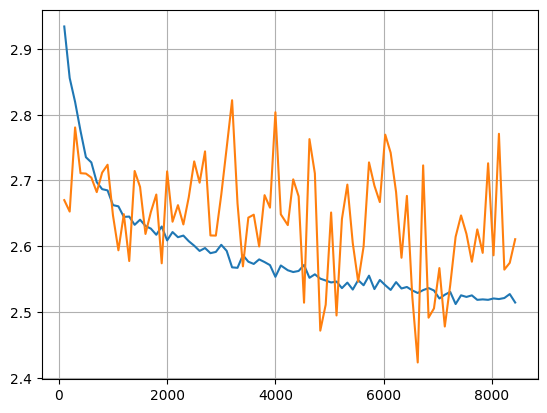

========== EPOCH 110 COMPLETED ==========
========== EPOCH 111 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


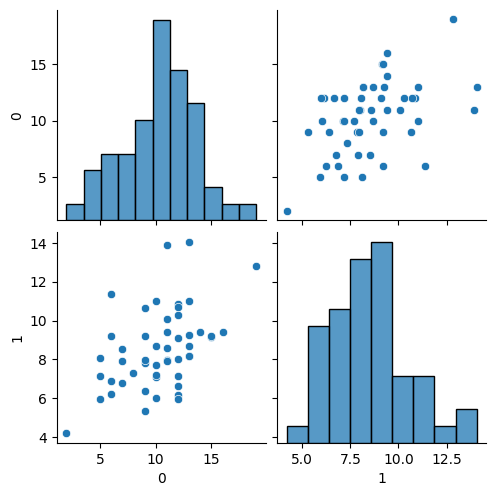

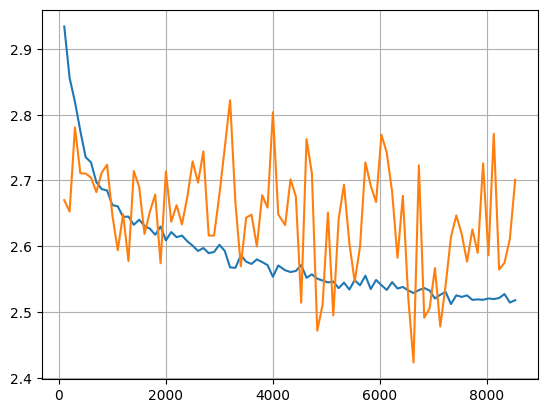

========== EPOCH 112 COMPLETED ==========
========== EPOCH 113 COMPLETED ==========
========== EPOCH 114 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


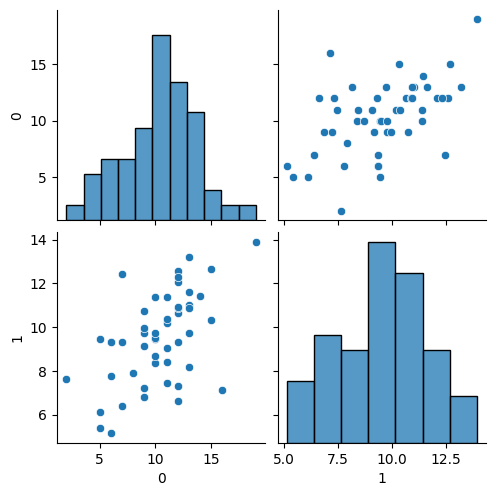

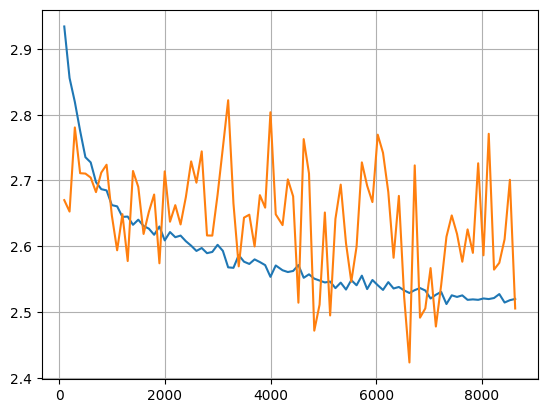

========== EPOCH 115 COMPLETED ==========
========== EPOCH 116 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


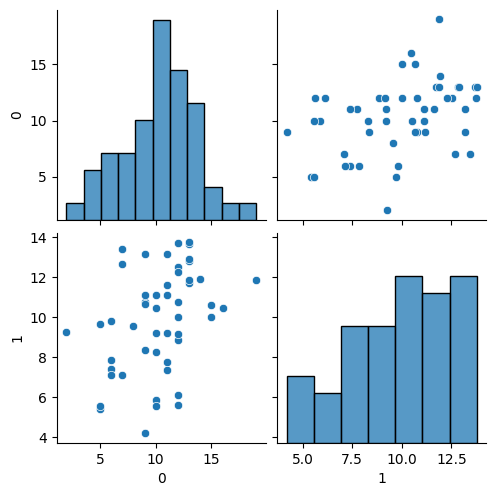

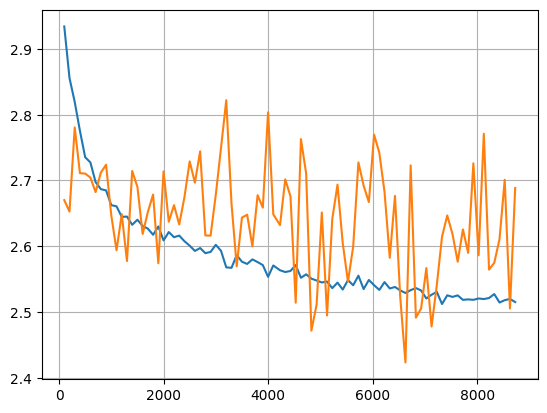

========== EPOCH 117 COMPLETED ==========
========== EPOCH 118 COMPLETED ==========
========== EPOCH 119 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


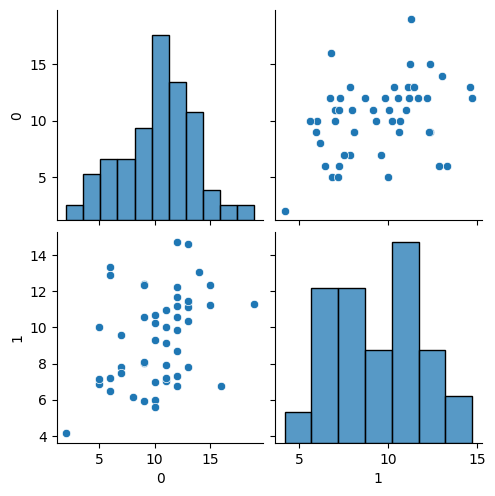

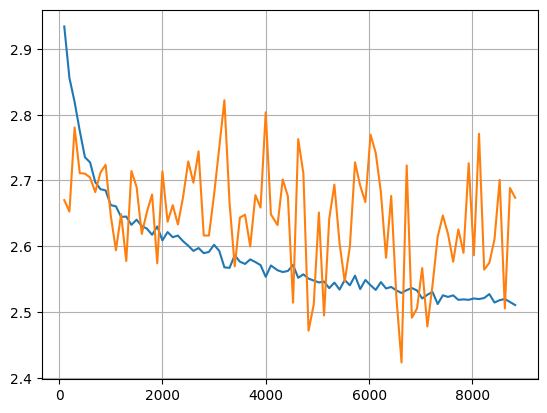

========== EPOCH 120 COMPLETED ==========
========== EPOCH 121 COMPLETED ==========
========== EPOCH 122 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


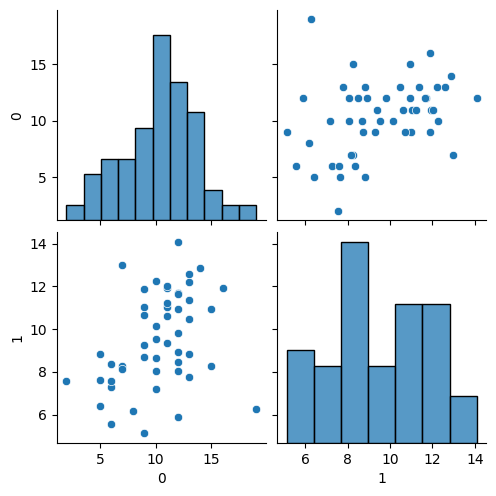

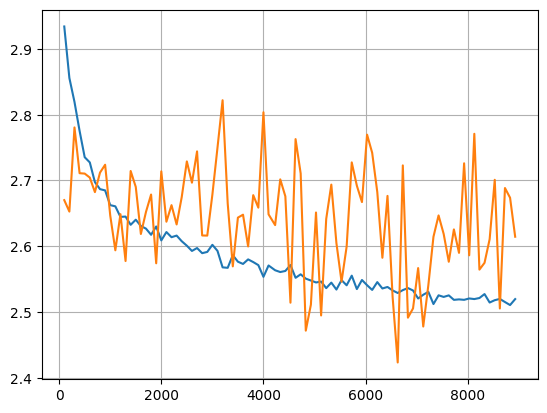

========== EPOCH 123 COMPLETED ==========
========== EPOCH 124 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


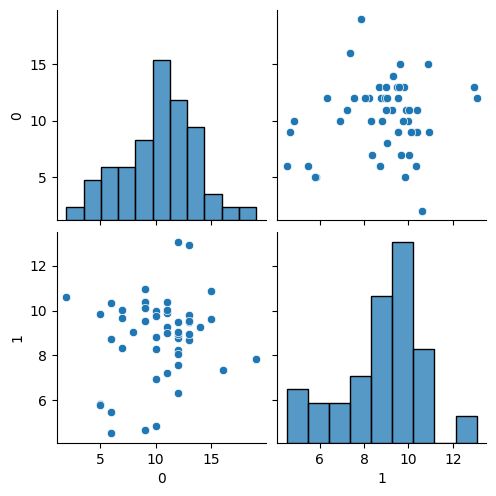

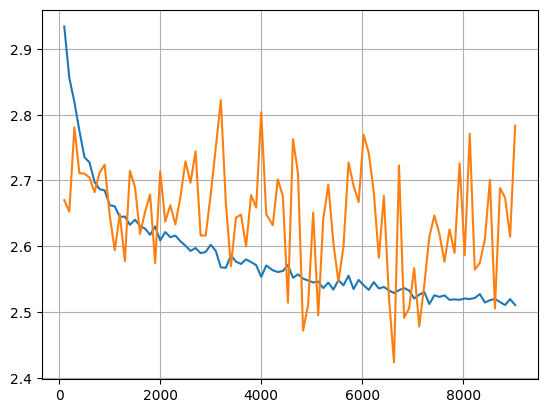

========== EPOCH 125 COMPLETED ==========
========== EPOCH 126 COMPLETED ==========
========== EPOCH 127 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


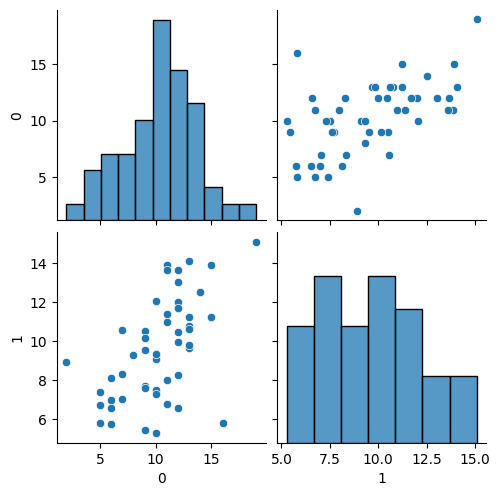

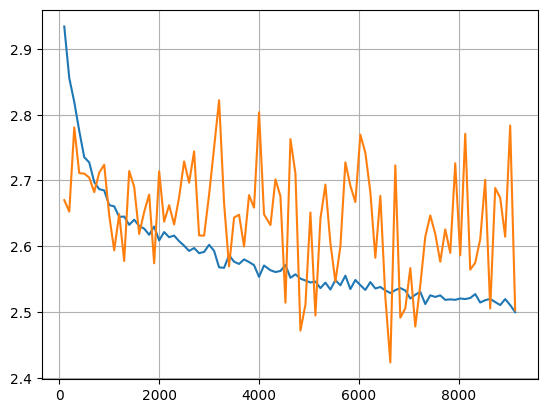

========== EPOCH 128 COMPLETED ==========
========== EPOCH 129 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


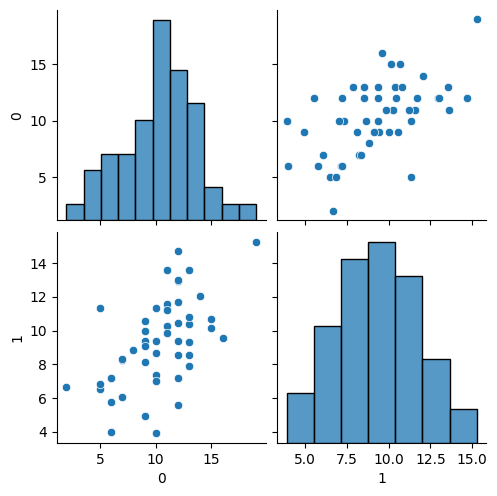

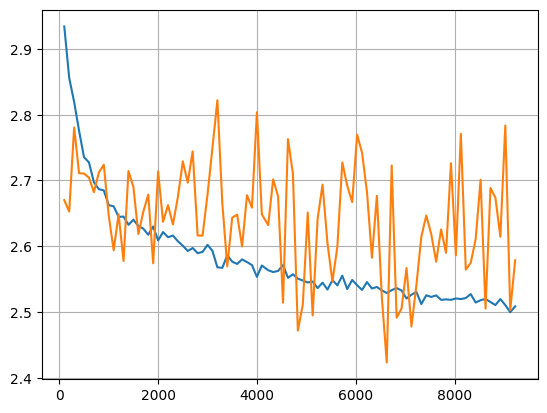

========== EPOCH 130 COMPLETED ==========
========== EPOCH 131 COMPLETED ==========
========== EPOCH 132 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


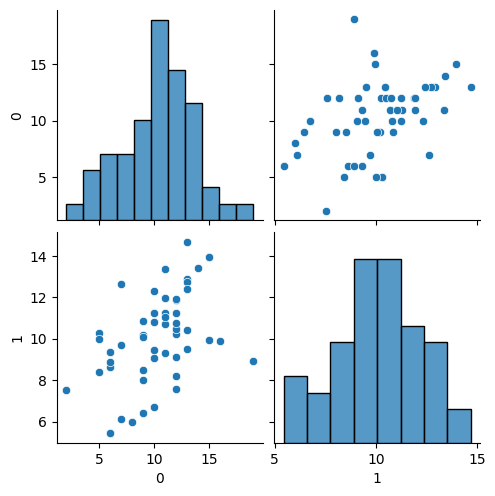

========== EPOCH 133 COMPLETED ==========
========== EPOCH 134 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


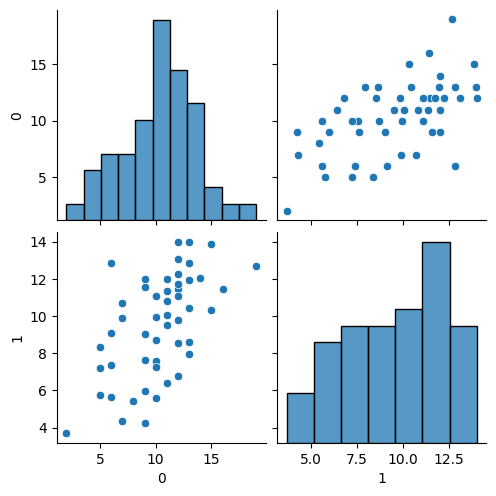

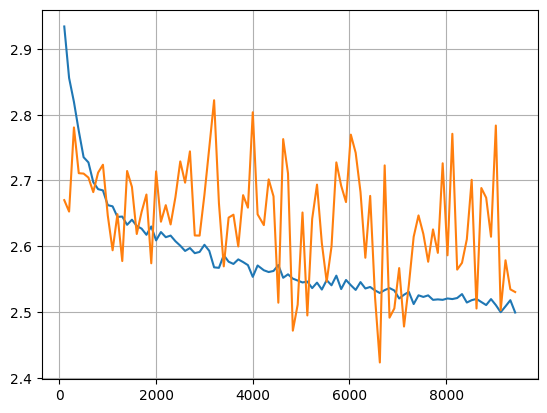

========== EPOCH 135 COMPLETED ==========
========== EPOCH 136 COMPLETED ==========
========== EPOCH 137 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


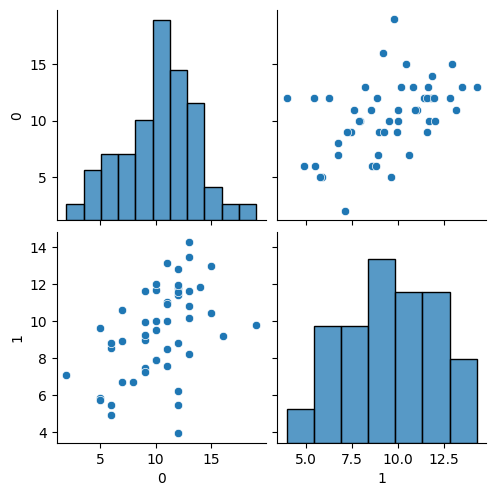

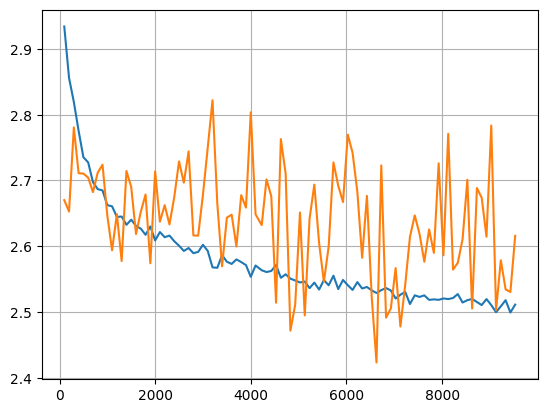

========== EPOCH 138 COMPLETED ==========
========== EPOCH 139 COMPLETED ==========
========== EPOCH 140 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


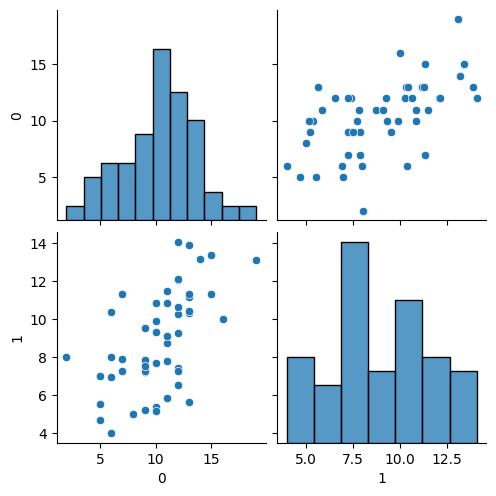

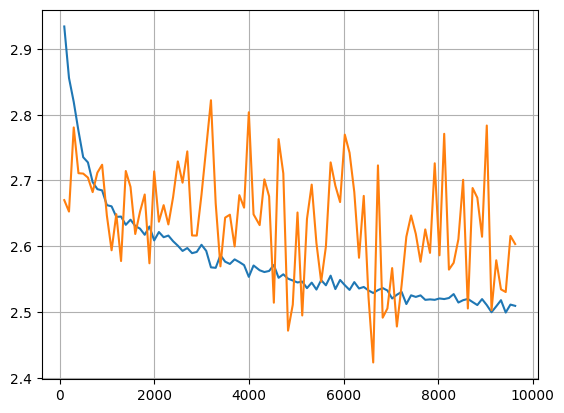

========== EPOCH 141 COMPLETED ==========
========== EPOCH 142 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


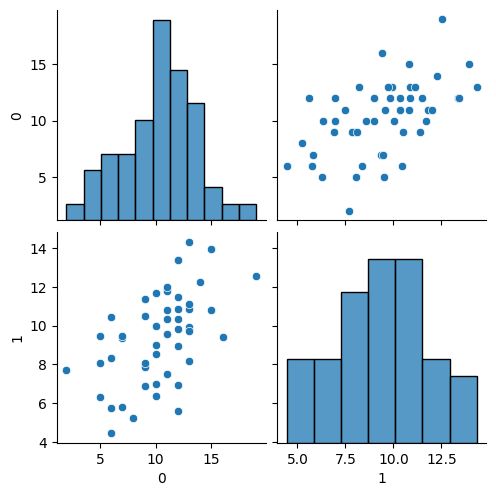

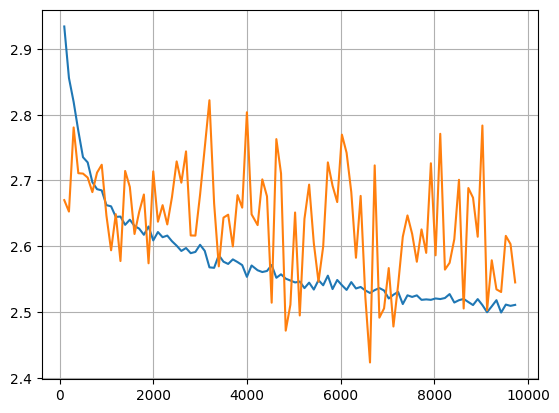

========== EPOCH 143 COMPLETED ==========
========== EPOCH 144 COMPLETED ==========
========== EPOCH 145 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


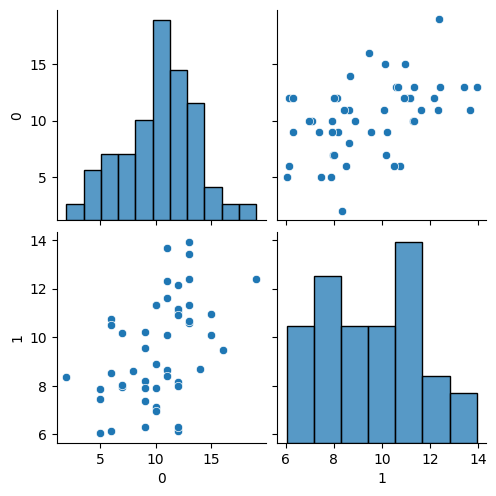

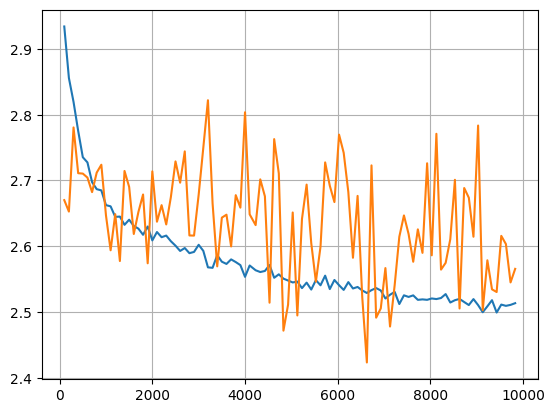

========== EPOCH 146 COMPLETED ==========
========== EPOCH 147 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


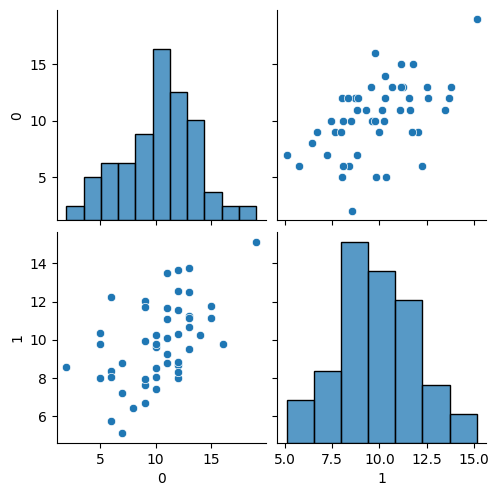

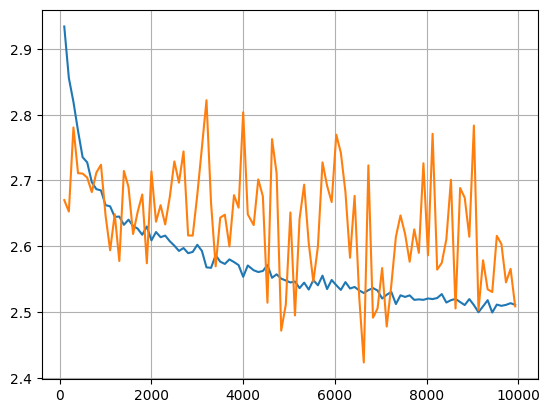

========== EPOCH 148 COMPLETED ==========
========== EPOCH 149 COMPLETED ==========
========== EPOCH 150 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


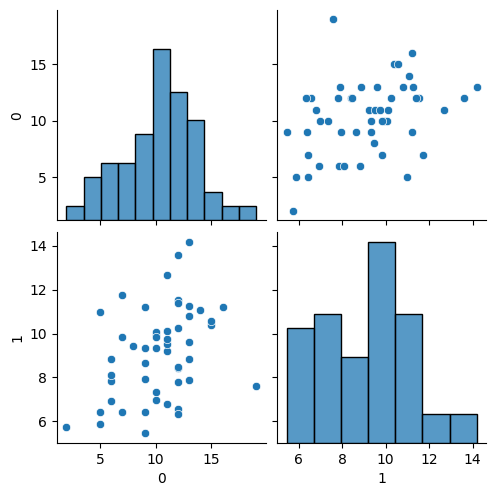

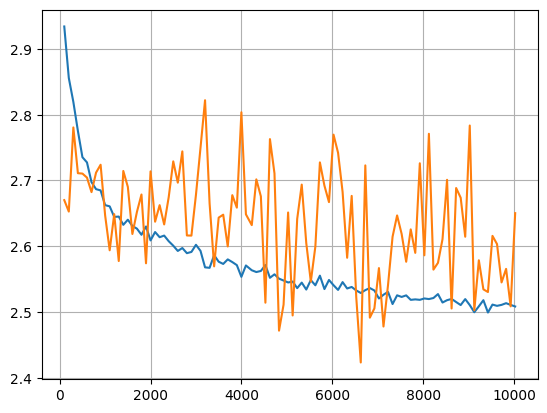

========== EPOCH 151 COMPLETED ==========
========== EPOCH 152 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


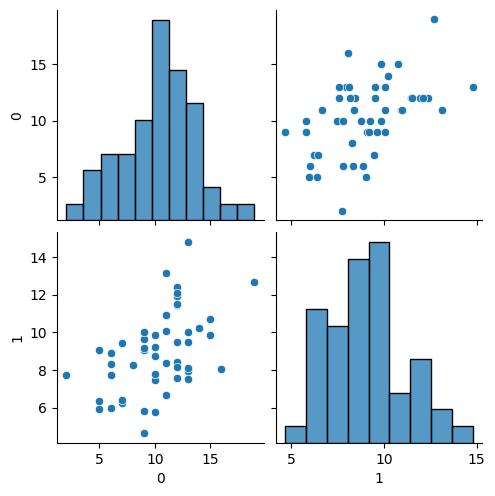

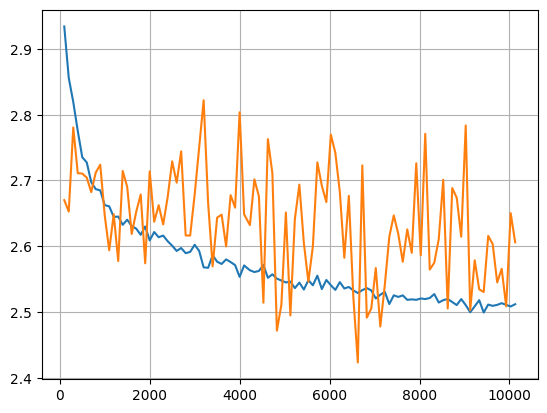

========== EPOCH 153 COMPLETED ==========
========== EPOCH 154 COMPLETED ==========
========== EPOCH 155 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


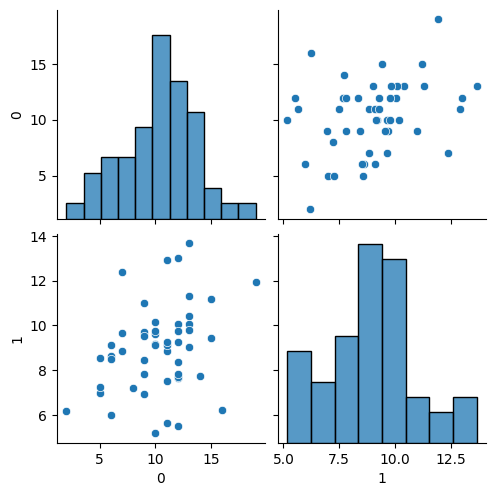

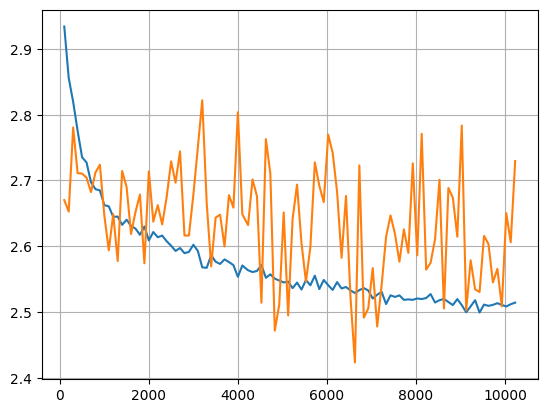

========== EPOCH 156 COMPLETED ==========
========== EPOCH 157 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


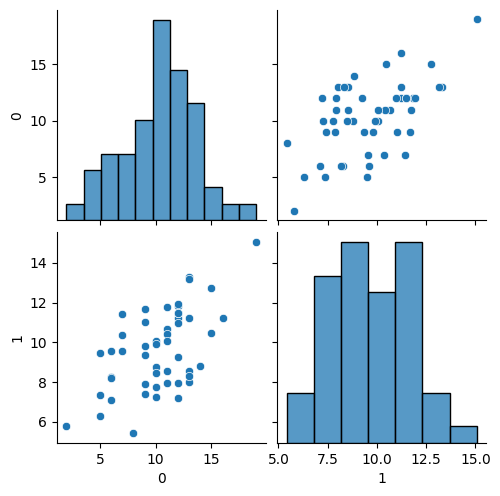

========== EPOCH 158 COMPLETED ==========


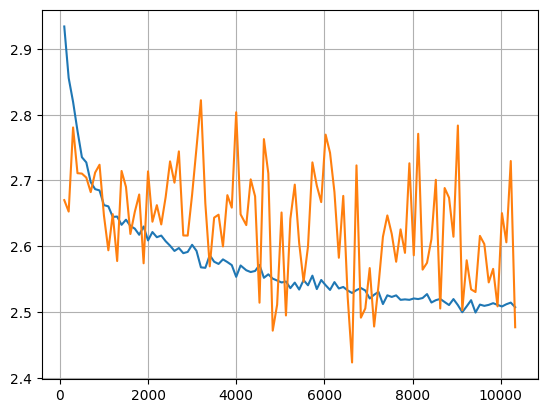

========== EPOCH 159 COMPLETED ==========
========== EPOCH 160 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


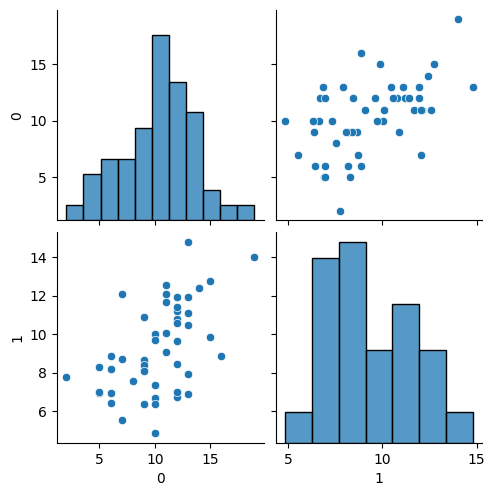

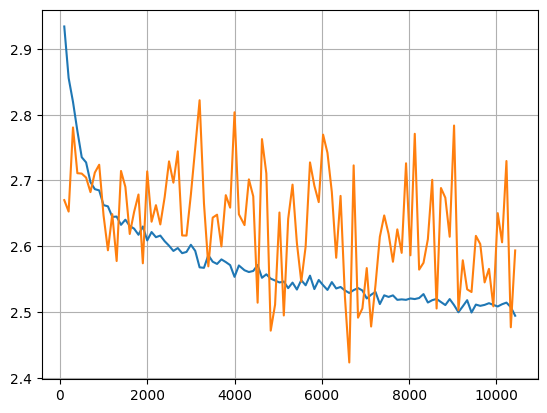

========== EPOCH 161 COMPLETED ==========
========== EPOCH 162 COMPLETED ==========
========== EPOCH 163 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


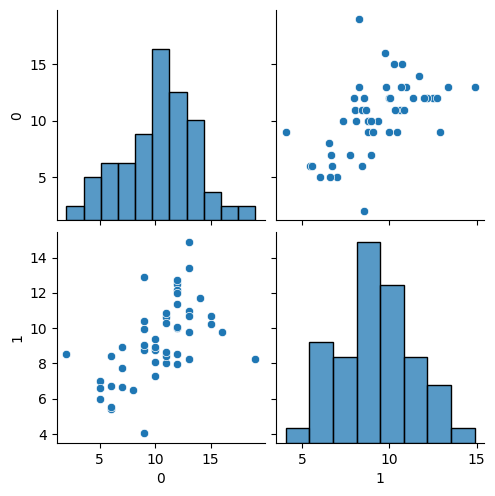

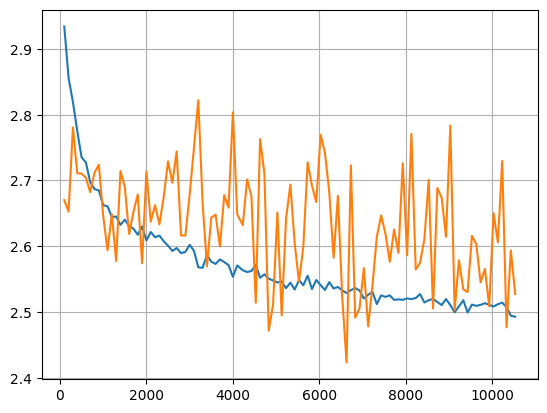

========== EPOCH 164 COMPLETED ==========
========== EPOCH 165 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


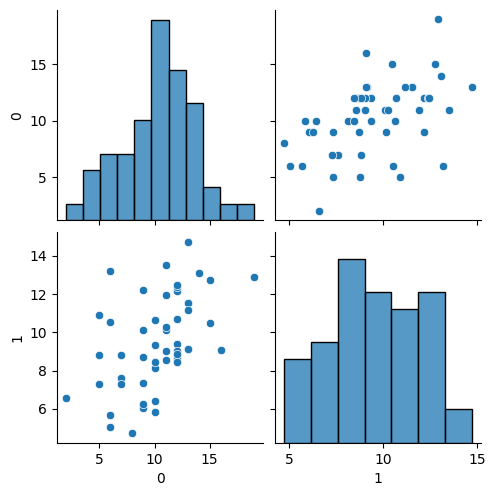

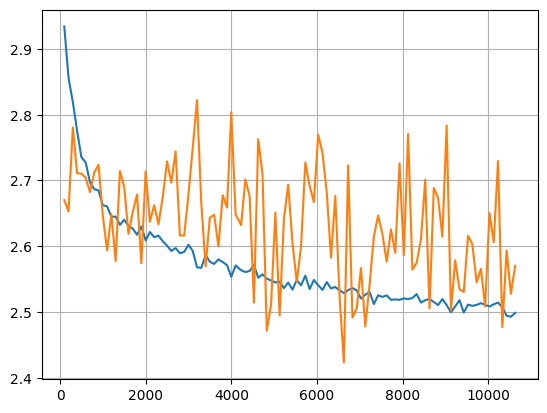

========== EPOCH 166 COMPLETED ==========
========== EPOCH 167 COMPLETED ==========
========== EPOCH 168 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


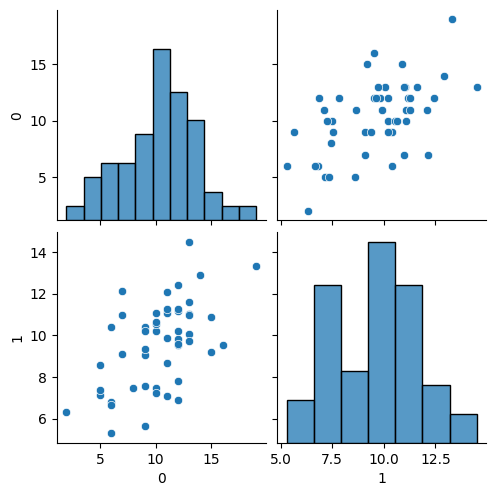

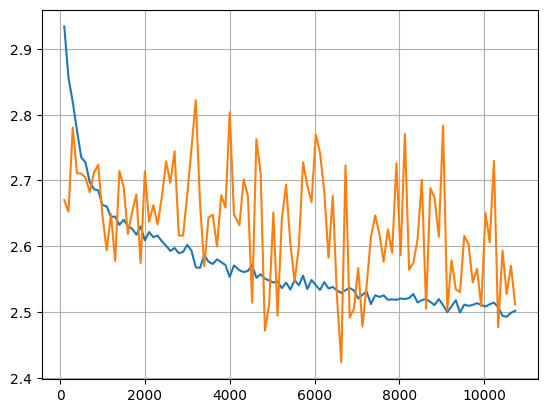

========== EPOCH 169 COMPLETED ==========
========== EPOCH 170 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


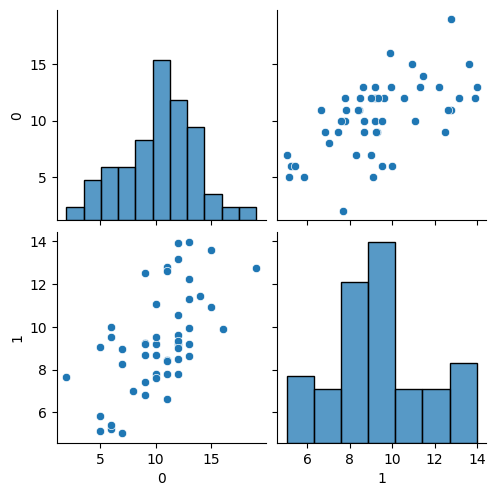

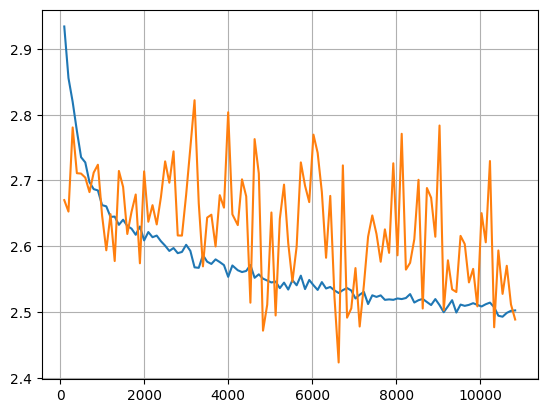

========== EPOCH 171 COMPLETED ==========
========== EPOCH 172 COMPLETED ==========
========== EPOCH 173 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


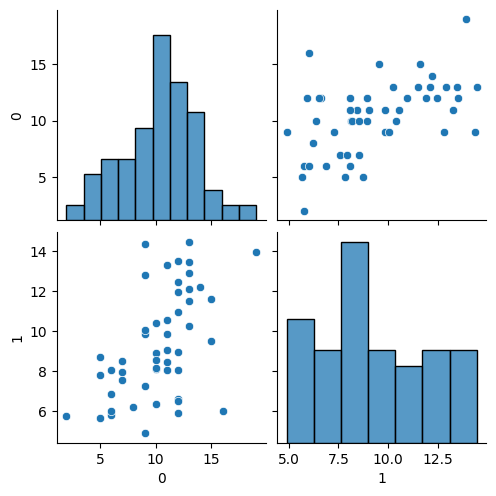

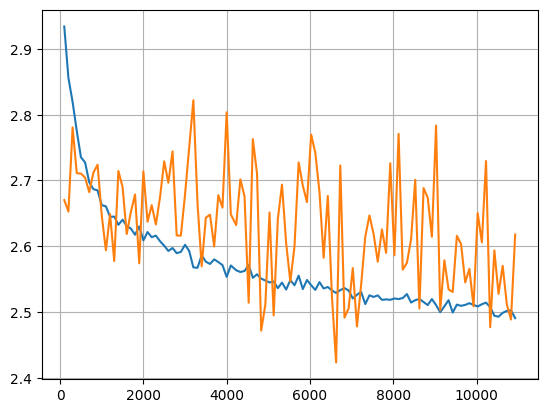

========== EPOCH 174 COMPLETED ==========
========== EPOCH 175 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


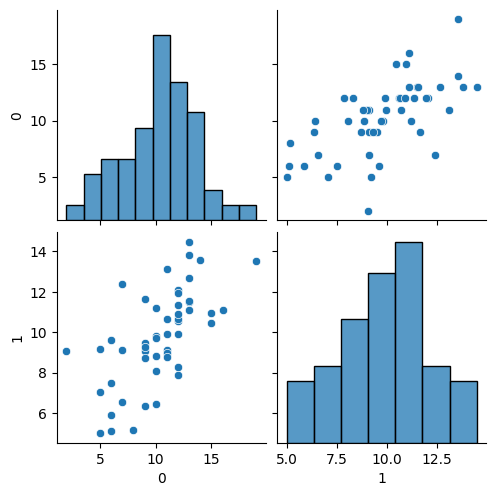

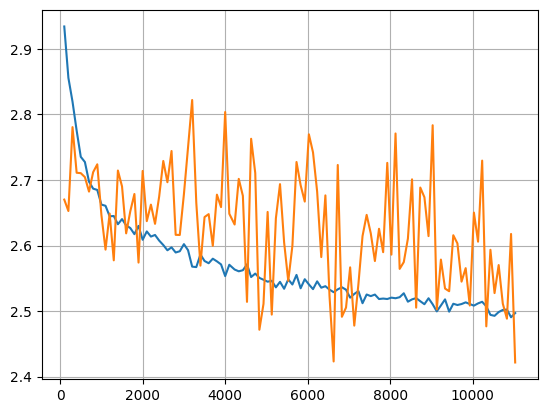

========== EPOCH 176 COMPLETED ==========
========== EPOCH 177 COMPLETED ==========
========== EPOCH 178 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


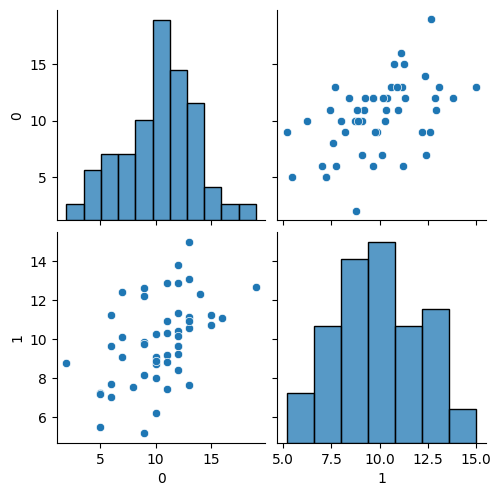

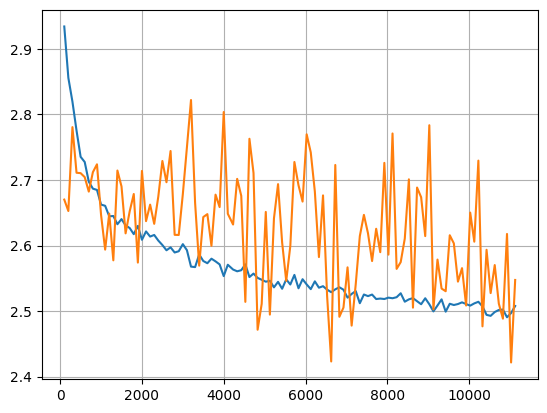

========== EPOCH 179 COMPLETED ==========
========== EPOCH 180 COMPLETED ==========
========== EPOCH 181 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


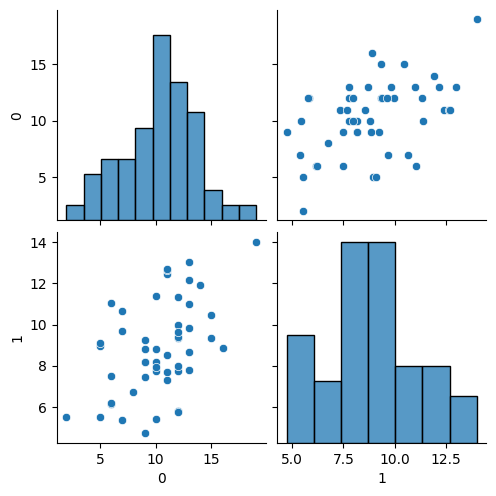

========== EPOCH 182 COMPLETED ==========
========== EPOCH 183 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


========== EPOCH 184 COMPLETED ==========
========== EPOCH 185 COMPLETED ==========
========== EPOCH 186 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


========== EPOCH 187 COMPLETED ==========
========== EPOCH 188 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


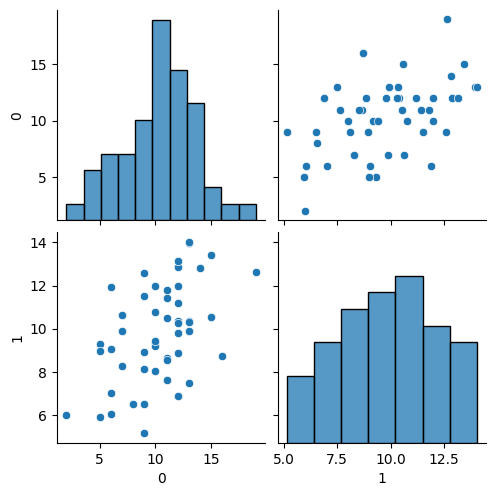

========== EPOCH 189 COMPLETED ==========
========== EPOCH 190 COMPLETED ==========
========== EPOCH 191 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


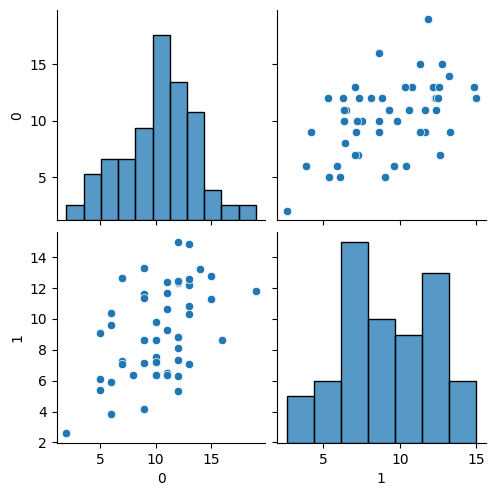

========== EPOCH 192 COMPLETED ==========
========== EPOCH 193 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


========== EPOCH 194 COMPLETED ==========
========== EPOCH 195 COMPLETED ==========
========== EPOCH 196 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


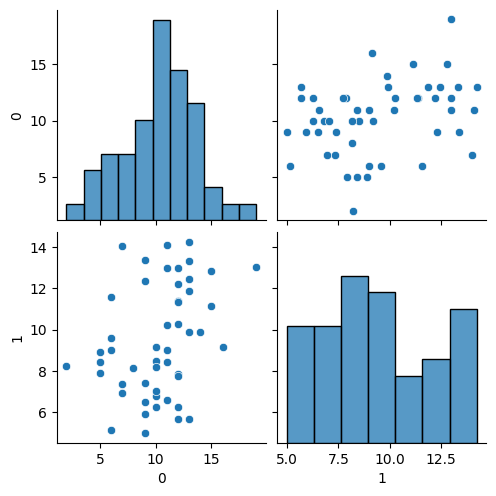

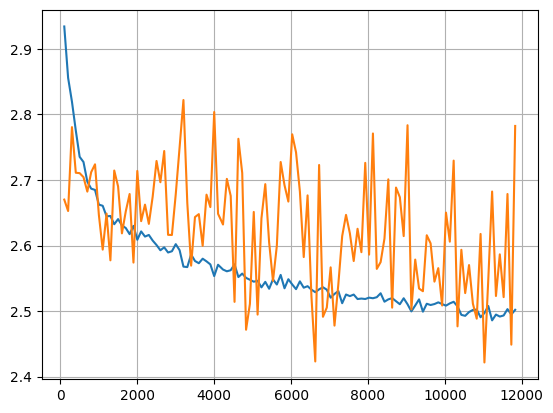

========== EPOCH 197 COMPLETED ==========
========== EPOCH 198 COMPLETED ==========
========== EPOCH 199 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


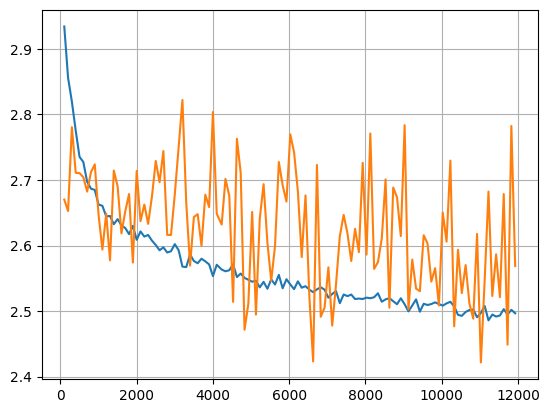

========== EPOCH 200 COMPLETED ==========
========== EPOCH 201 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


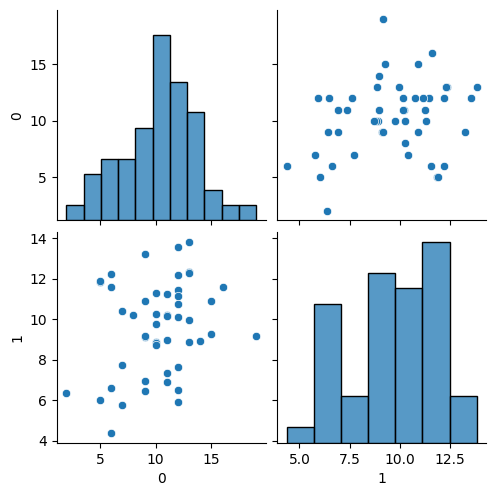

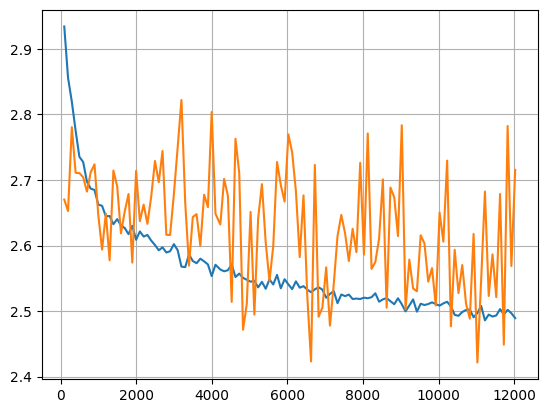

========== EPOCH 202 COMPLETED ==========
========== EPOCH 203 COMPLETED ==========
========== EPOCH 204 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


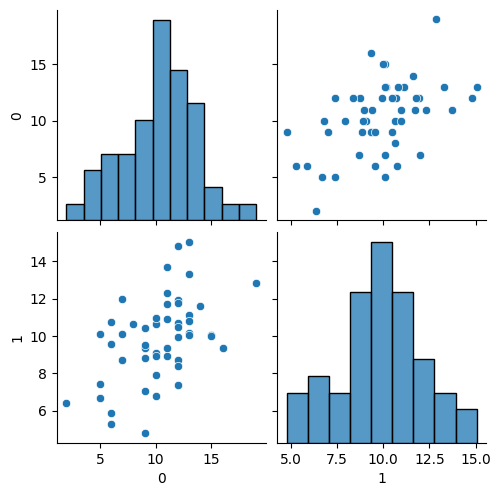

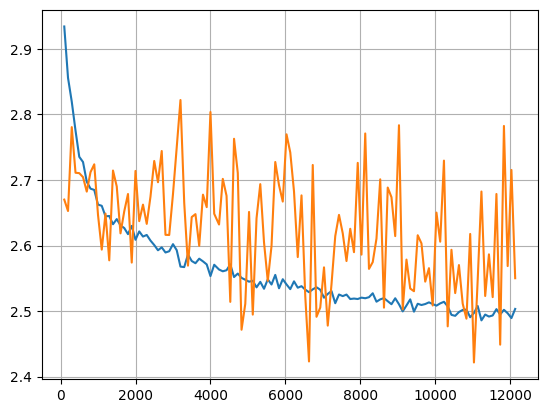

========== EPOCH 205 COMPLETED ==========
========== EPOCH 206 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


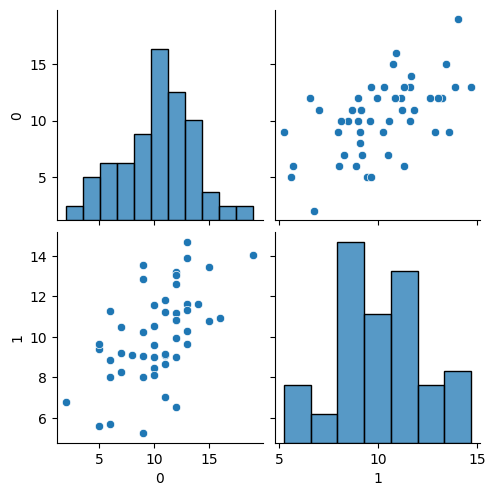

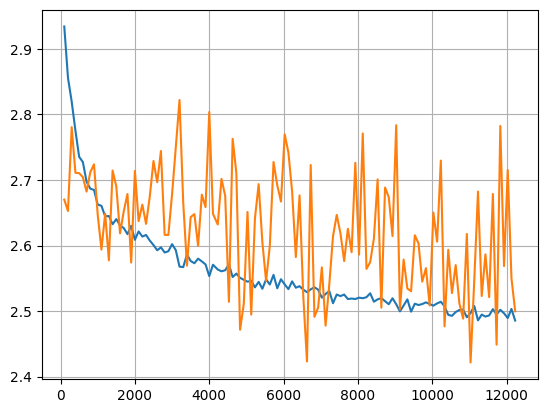

========== EPOCH 207 COMPLETED ==========
========== EPOCH 208 COMPLETED ==========
========== EPOCH 209 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


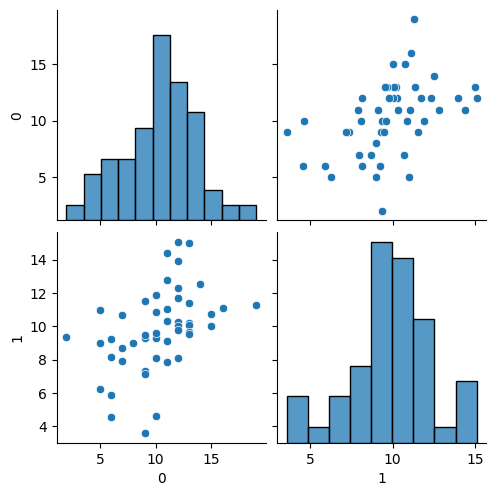

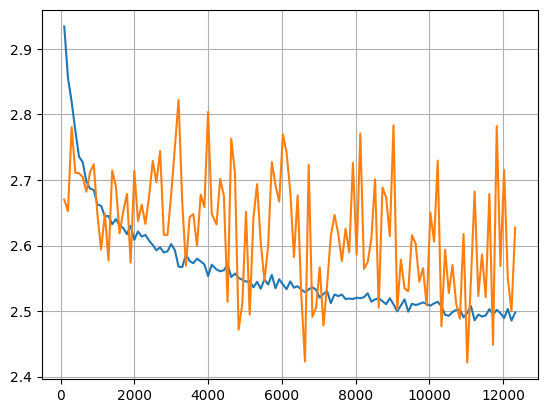

========== EPOCH 210 COMPLETED ==========
========== EPOCH 211 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


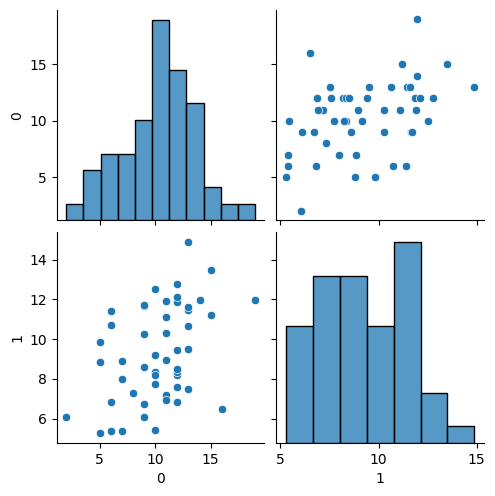

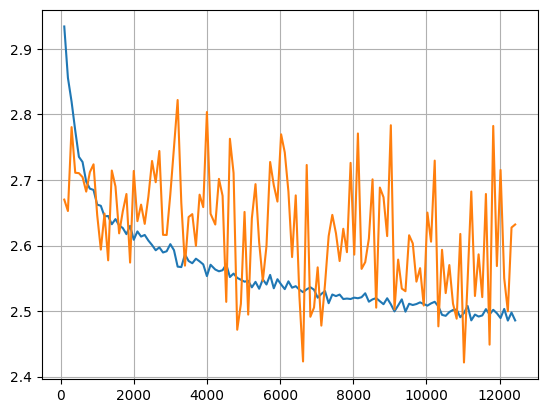

========== EPOCH 212 COMPLETED ==========
========== EPOCH 213 COMPLETED ==========
========== EPOCH 214 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


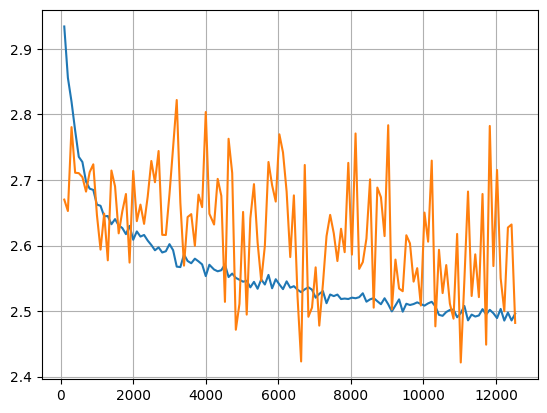

========== EPOCH 215 COMPLETED ==========
========== EPOCH 216 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


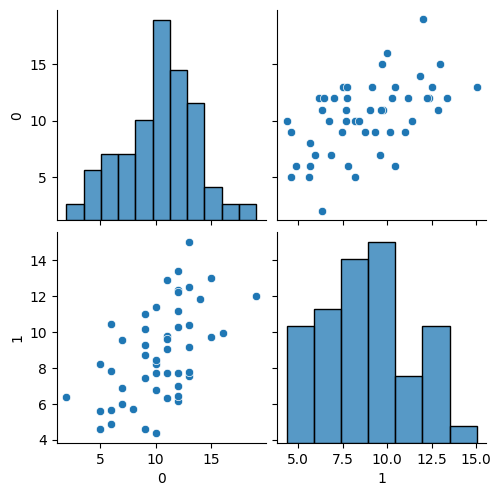

========== EPOCH 217 COMPLETED ==========
========== EPOCH 218 COMPLETED ==========
========== EPOCH 219 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


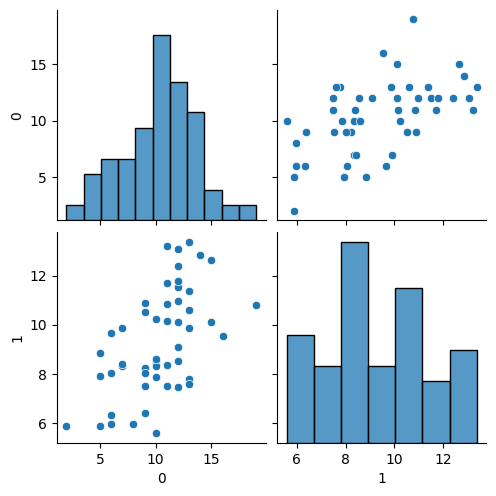

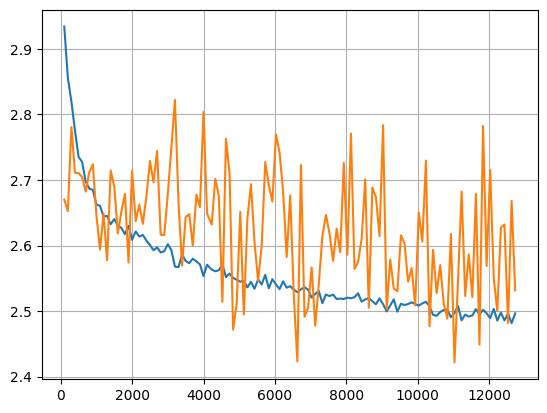

========== EPOCH 220 COMPLETED ==========
========== EPOCH 221 COMPLETED ==========
========== EPOCH 222 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


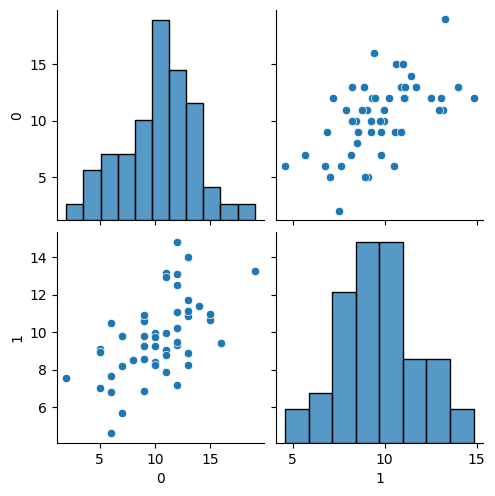

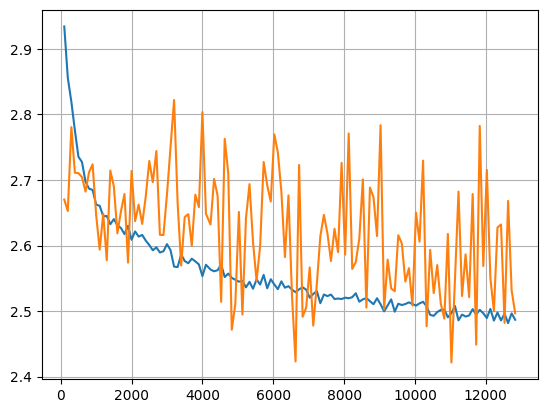

========== EPOCH 223 COMPLETED ==========
========== EPOCH 224 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


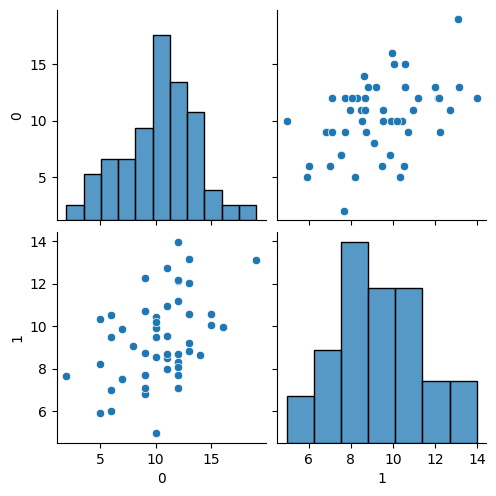

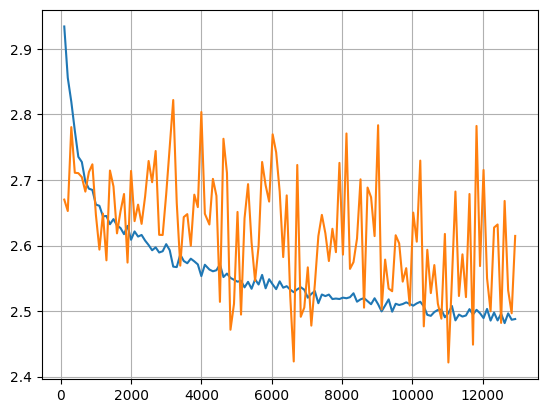

========== EPOCH 225 COMPLETED ==========
========== EPOCH 226 COMPLETED ==========
========== EPOCH 227 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


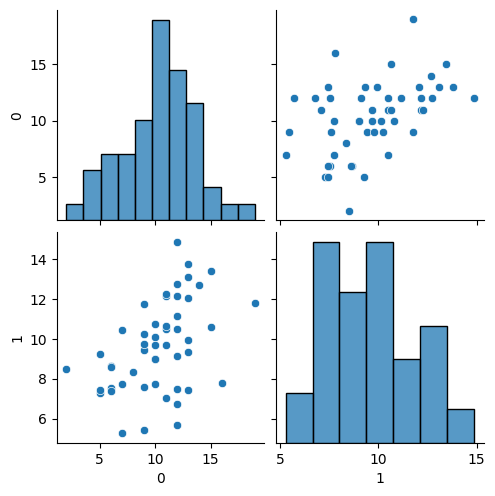

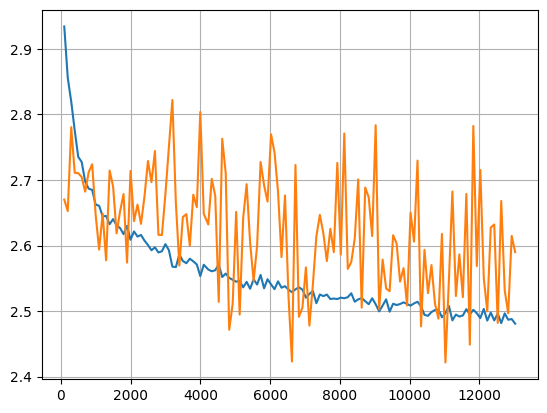

========== EPOCH 228 COMPLETED ==========
========== EPOCH 229 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


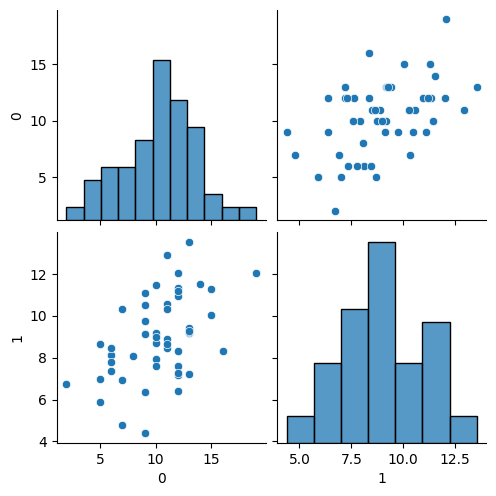

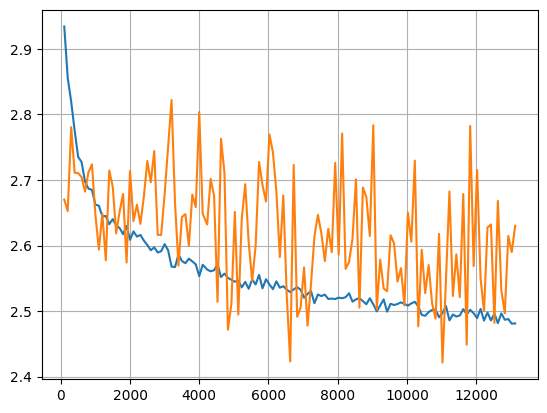

========== EPOCH 230 COMPLETED ==========
========== EPOCH 231 COMPLETED ==========
========== EPOCH 232 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


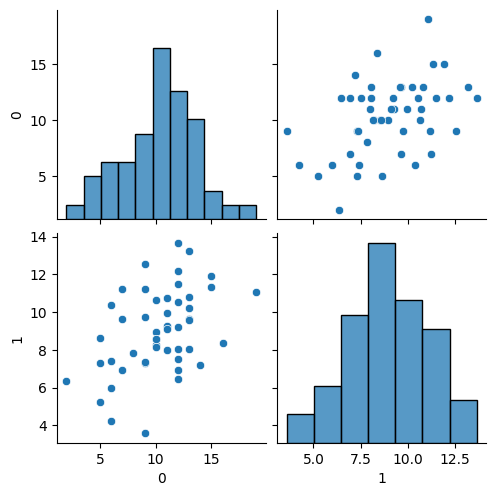

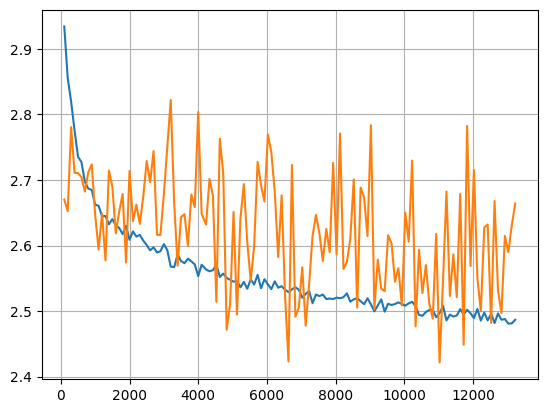

========== EPOCH 233 COMPLETED ==========
========== EPOCH 234 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


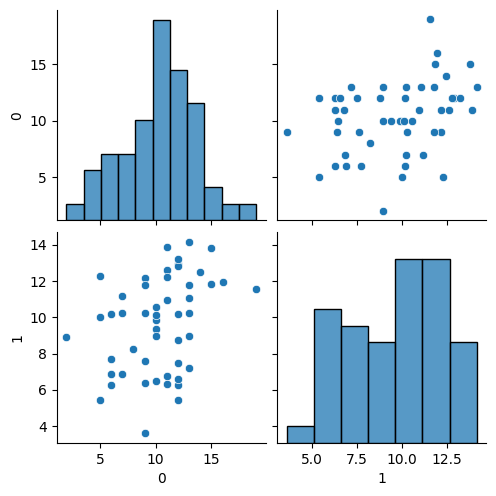

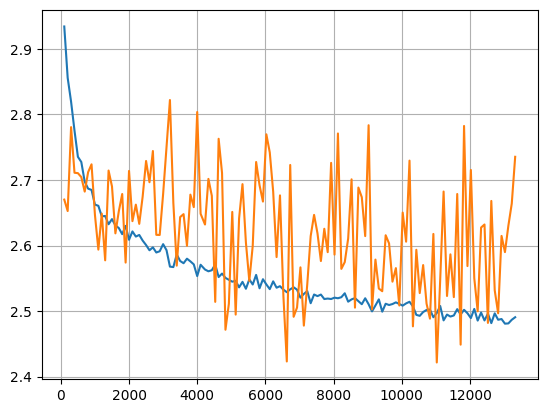

========== EPOCH 235 COMPLETED ==========
========== EPOCH 236 COMPLETED ==========
========== EPOCH 237 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


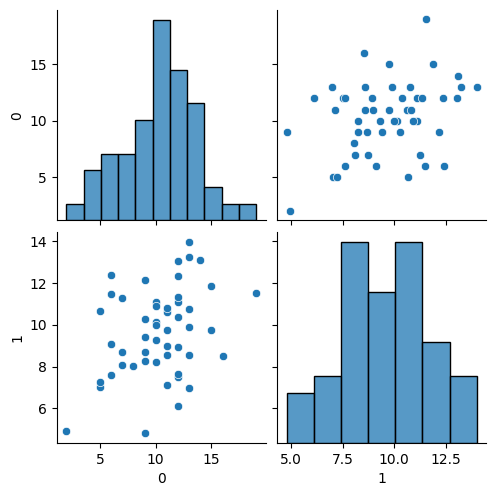

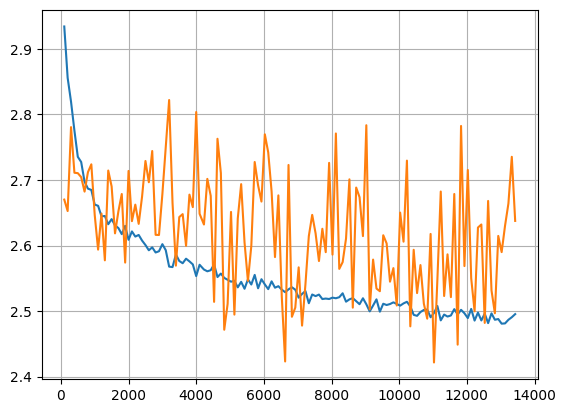

========== EPOCH 238 COMPLETED ==========
========== EPOCH 239 COMPLETED ==========
========== EPOCH 240 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


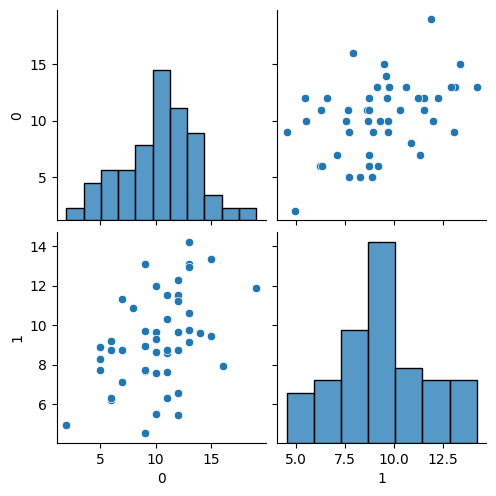

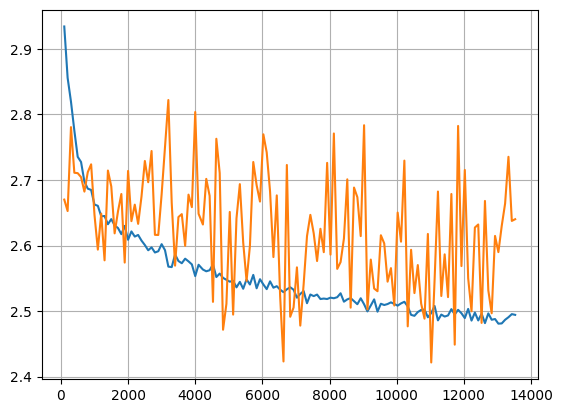

========== EPOCH 241 COMPLETED ==========
========== EPOCH 242 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


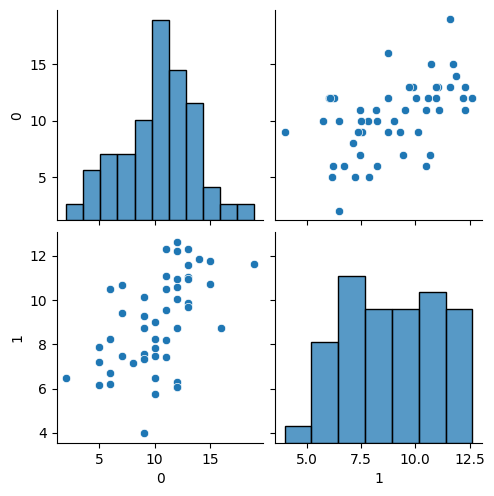

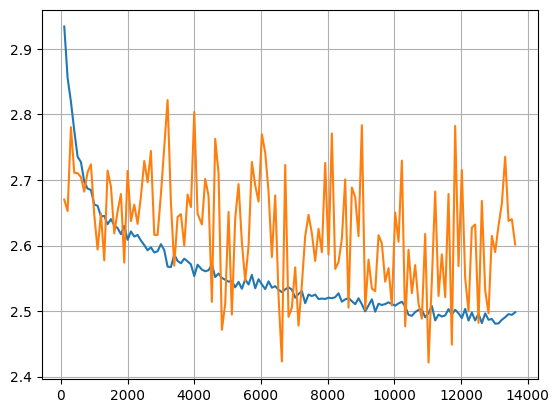

========== EPOCH 243 COMPLETED ==========
========== EPOCH 244 COMPLETED ==========
========== EPOCH 245 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


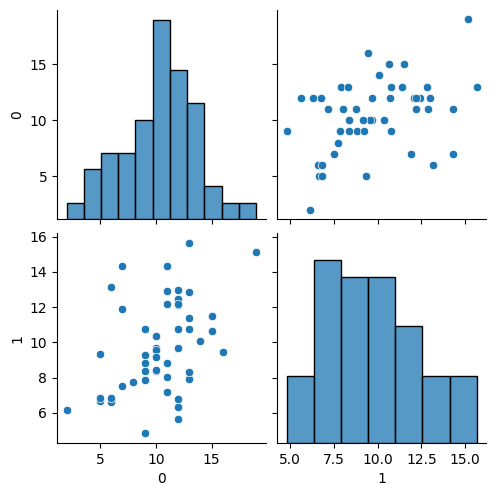

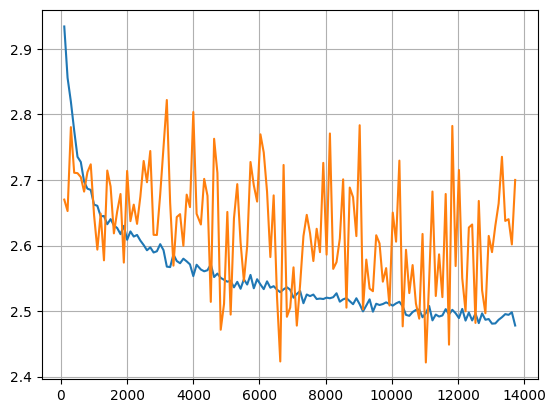

========== EPOCH 246 COMPLETED ==========
========== EPOCH 247 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


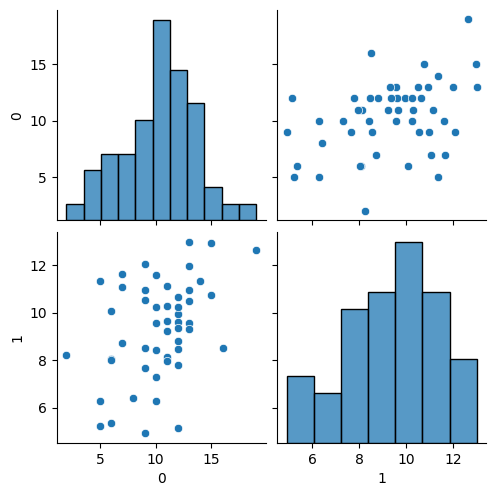

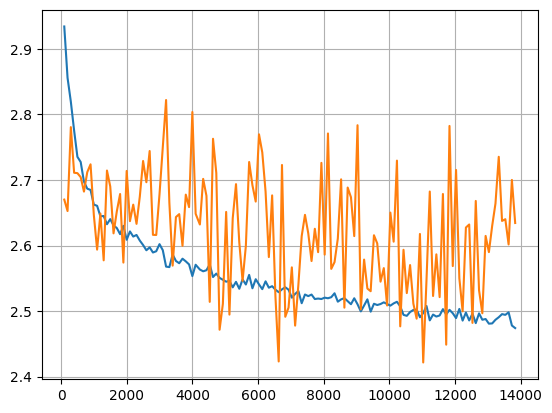

========== EPOCH 248 COMPLETED ==========
========== EPOCH 249 COMPLETED ==========
========== EPOCH 250 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


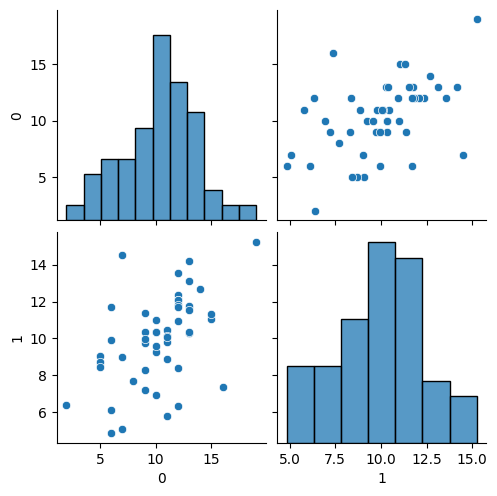

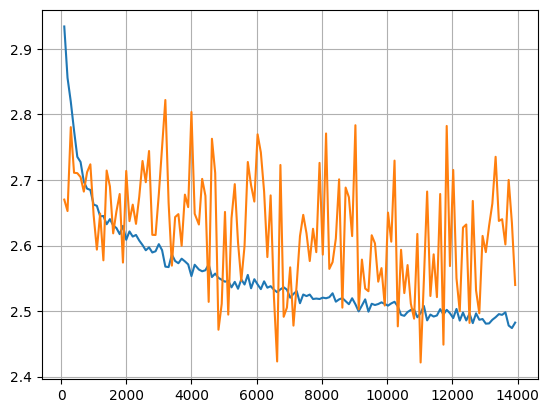

========== EPOCH 251 COMPLETED ==========
========== EPOCH 252 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


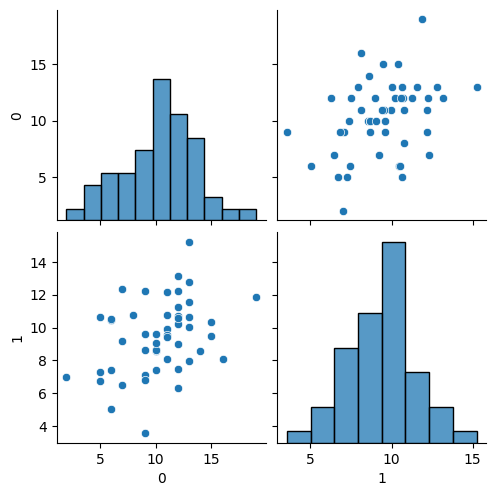

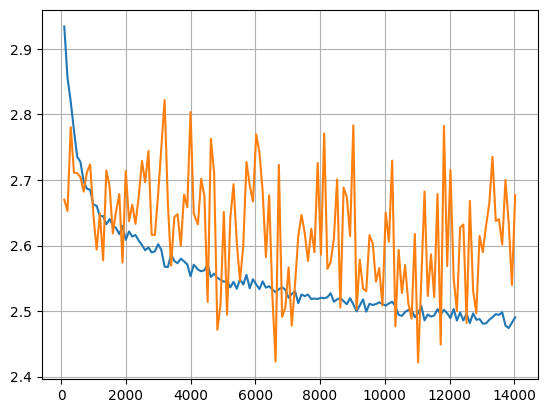

========== EPOCH 253 COMPLETED ==========
========== EPOCH 254 COMPLETED ==========
========== EPOCH 255 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


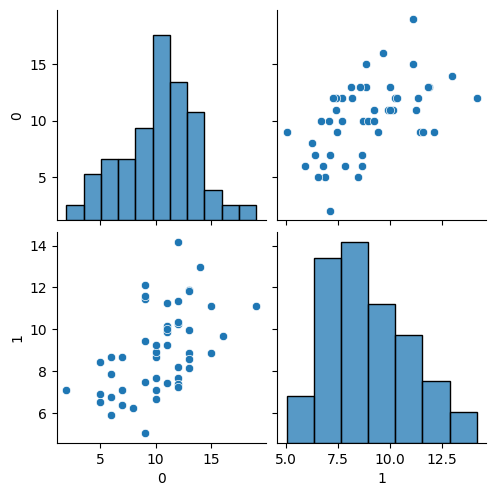

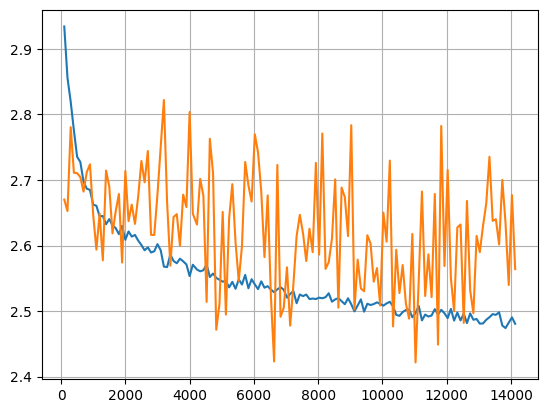

========== EPOCH 256 COMPLETED ==========
========== EPOCH 257 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


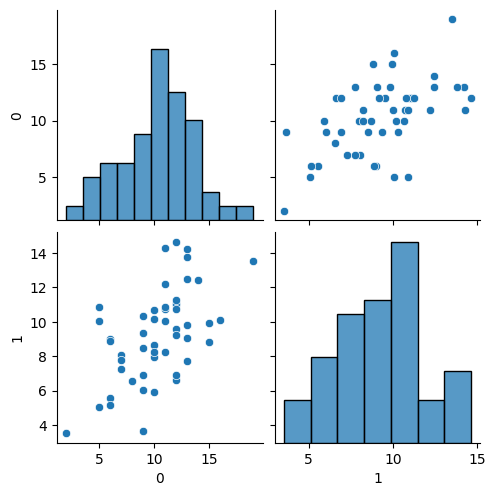

========== EPOCH 258 COMPLETED ==========


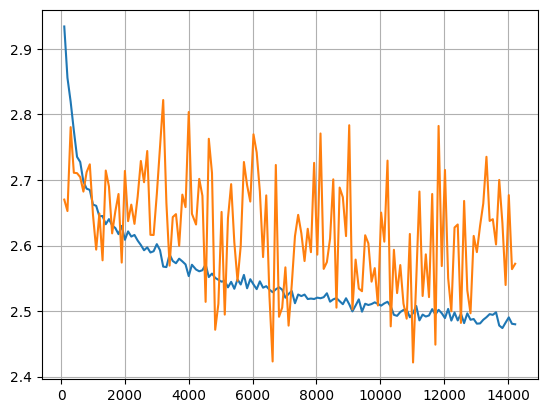

========== EPOCH 259 COMPLETED ==========
========== EPOCH 260 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


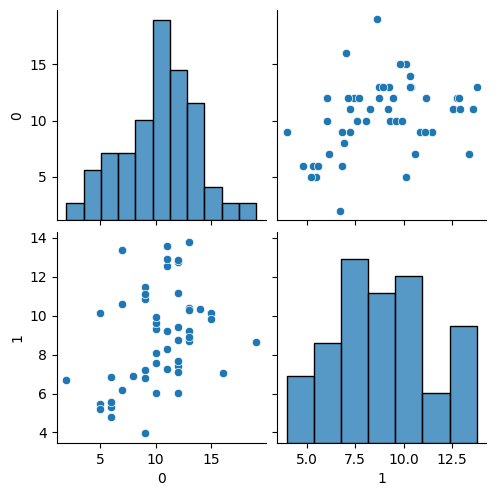

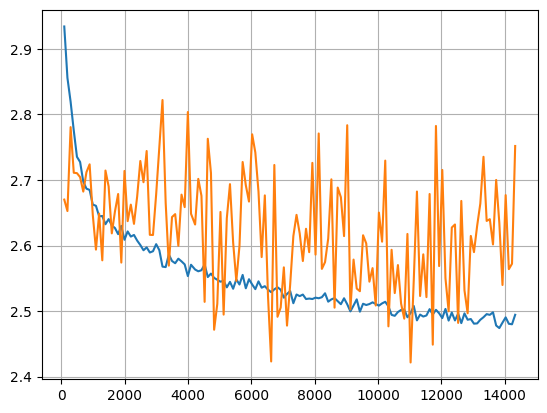

========== EPOCH 261 COMPLETED ==========


KeyboardInterrupt: 

In [21]:
losses = []
vlosses = []
vmin = 9999

for k in trange(999999):
    loss = Loss()
    loss.backward()
    losses.append(loss.item())
    net.optim.step()
    net.optim.zero_grad()
    
    if len(losses) == 100:
        vloss = valloss(plot=True).item()
        if vloss < vmin:
            vmin = vloss
            torch.save(net.state_dict(), 'rd_weights_281123.dat')
        net.losses.append((net.iters, np.mean(losses)))
        net.vlosses.append((net.iters, vloss))
        losses = []
    net.iters += 1
    
    if k % 100 == 0:
        plt.plot(*zip(*net.losses))
        plt.plot(*zip(*net.vlosses))
        #plt.ylim([0,50])
        plt.grid()
        plt.show()

# 4.5 s / it
# RTX 3080: 5 it / s

<All keys matched successfully>

## Zwei Beispielsätze: Ein einfacher und ein schwerer

In [ ]:
net.load_state_dict(torch.load('rd_weights_281123.dat'))

0.4062965373617772


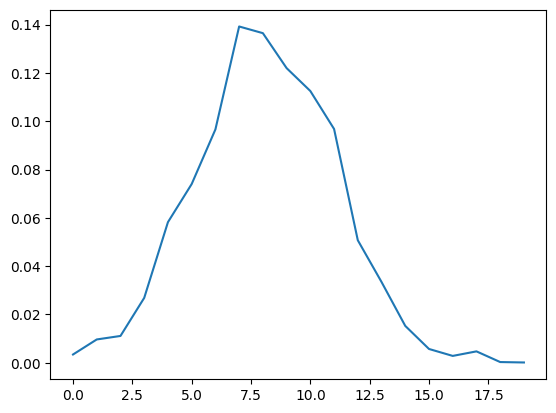

In [25]:
import bpe
net.eval()
x = encode(bpe.encode('Internalization is when people have actually internalized a group\'s belief system and see it as truly their own,...', tokenizer.bpe_code), evl=False)
x = encode(bpe.encode('they left them bound, but gave them provisions, and promised them, if they continued there quietly, to give them their liberty in a day or two; but that', tokenizer.bpe_code), evl=False)
#x = encode(bpe.encode('This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator.', tokenizer.bpe_code), evl=False)
xs = np2t([x])
with torch.no_grad(): zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(zp)
print(np.sum(np.arange(NBINS)*zp) / NBINS)

0.6121305573513383


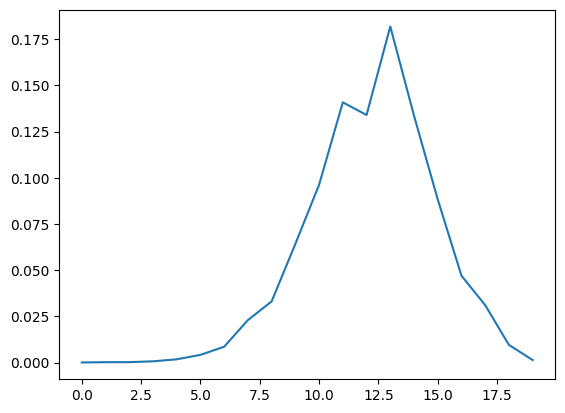

In [27]:
import bpe
net.eval()
x = encode(bpe.encode('Most people know that physical activity is important for their physical health. People who are more physically...', tokenizer.bpe_code), evl=False)
x = encode(bpe.encode('There was once a young man who spent all his time in traveling. One day, as he was walking along, he picked up a snuffbox', tokenizer.bpe_code), evl=False)
xs = np2t([x])
zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(zp)
print(np.sum(np.arange(NBINS)*zp) / NBINS)

0.33066991641680943


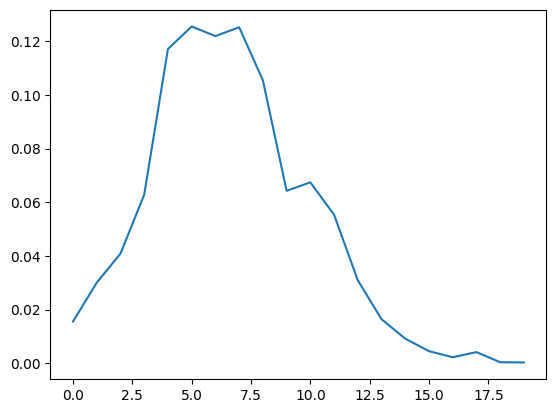

In [28]:
import bpe
net.eval()
x = encode(bpe.encode('In a column of fluid, pressure increases with depth as a result of the weight of the overlying fluid. Thus the pressure at the bottom of a column of fluid is greater than at the top ...', tokenizer.bpe_code), evl=False)
#x = encode(bpe.encode('There was once a young man who spent all his time in traveling. One day, as he was walking along, he picked up a snuffbox', tokenizer.bpe_code), evl=False)
xs = np2t([x])
zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(zp)
print(np.sum(np.arange(NBINS)*zp) / NBINS)

0.7593416755876206


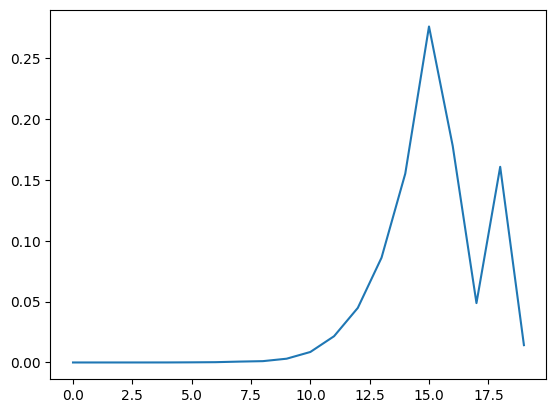

In [29]:
import bpe
net.eval()
#x = encode(bpe.encode('In a column of fluid, pressure increases with depth as a result of the weight of the overlying fluid. Thus the pressure at the bottom of a column of fluid is greater than at the top ...', tokenizer.bpe_code), evl=False)
x = encode(bpe.encode('When Grandmother Lane was a little girl her father came in one day and said, "Wife, it is all settled at last. I have sold the farm. Next week we will start West...', tokenizer.bpe_code), evl=False)
xs = np2t([x])
zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(zp)
print(np.sum(np.arange(NBINS)*zp) / NBINS)

## Korrelation anzeigen und Ausgleichsgerade

In [ ]:
net.eval()
bsize = 50
inds = range(len(df_val))
minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
zps, zss = [], []
for mb in tqdm(minibatches):
    xs, zs, zs2 = [], [], []
    for i in mb:
        x = df_val['encoded'][i]
        z = df_val['target'][i]
        x = encode(x)
        z2 = z
        z = target_bin(z)
        xs.append(x)
        zs.append(z)
        zs2.append(z2)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    zp = F.softmax(zp, dim=1)
    zp, zs = t2np(zp, zs)
    zp = np.sum(zp * np.arange(NBINS), -1)
    zps.append(zp)
    zss.append(zs2)

zp = np.concatenate(zps)
zs = np.concatenate(zss)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Beispiel-Datenpunkte
xs = zs
ys = zp

# Lineare Regression
slope, intercept = np.polyfit(xs, ys, 1)

# Erstellen der Ausgleichsgeraden
fit_line = np.polyval([slope, intercept], xs)

# Plot der Datenpunkte und der Ausgleichsgeraden
plt.scatter(xs, ys, s=5, label='Datenpunkte')
plt.plot(xs, fit_line, color='darkred', label='Ausgleichsgerade')
#plt.legend()
#plt.axis('equal')
plt.axis('off')

## Test Datenset evaluieren

In [ ]:
df_test = pd.read_csv(path+'encoded_test.csv')
net.eval()
xs = []
for i in range(len(df_test)):
    x = df_test['encoded'][i]
    x = encode(x)
    xs.append(x)
xs = np2t(xs)
zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)
zp = np.sum(zp * np.arange(NBINS), -1) / NBINS

In [ ]:
zp